https://www.techscience.com/iasc/v36n1/49992/html
- 50 Epoch
- Batch Size 20
- Image size of 416

**References:**
1. https://www.youtube.com/watch?v=Ciy1J97dbY0&ab_channel=LearnOpenCV
2. https://learnopencv.com/custom-object-detection-training-using-yolov5/
3. https://github.com/spmallick/learnopencv/tree/master/Custom-Object-Detection-Training-using-YOLOv5
4. https://colab.research.google.com/github/spmallick/learnopencv/blob/master/Custom-Object-Detection-Training-using-YOLOv5/Custom_Object_Detection_using_YOLOv5.ipynb

# **Import Libraries**

In [ ]:
import os
import collections
import glob as glob
import matplotlib.pyplot as plt
import matplotlib as mpl
import cv2
import requests
import random
import numpy as np
import pandas as pd
import yaml
from PIL import Image
import torch
import pickle
from datetime import datetime
import shutil
from IPython.display import Image, display

np.random.seed(42)

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# **Data Preparation**

## **Download Dataset**
Dataset di-download dari Huggingface. Di dalam Google Colab, dataset akan terstruktur seperti ini:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

In [ ]:
# Variable untuk link/url dataset
dataset_url="https://universe.roboflow.com/ds/SlQeB1URih?key=ID9muzCTOt"

In [ ]:
# Untuk download dan unzip dataset
if not os.path.exists('train'):
    !curl -L $dataset_url > yolov5_data.zip; unzip yolov5_data.zip; rm yolov5_data.zip
    
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

Streaming output truncated to the last 5000 lines.
 extracting: train/labels/004215_jpg.rf.9710d34f1eb79dc4ffae912e8ef13ddc.txt  
 extracting: train/labels/004215_jpg.rf.f208097589c36ad64cf8e64ac754fd62.txt  
 extracting: train/labels/004216_jpg.rf.0c8a3b5285257f284112091e7b8bd3f2.txt  
 extracting: train/labels/004216_jpg.rf.50d226b81288c6c90474769b607e86ca.txt  
 extracting: train/labels/004216_jpg.rf.ec794574e2f996ec897b44851f56c699.txt  
 extracting: train/labels/004217_jpg.rf.404f638fc9e82b412ab4fcc492378c3c.txt  
 extracting: train/labels/004217_jpg.rf.901e8a4b652a5bebfb219379fc21cfaa.txt  
 extracting: train/labels/004217_jpg.rf.b28705e13ee76ec0033d812610e60a2b.txt  
 extracting: train/labels/004218_jpg.rf.64e519c9560ecbd97aaee0f8893d8599.txt  
 extracting: train/labels/004218_jpg.rf.8a11edc70c07faab707cefce544f96b1.txt  
 extracting: train/labels/004218_jpg.rf.8eeafd0b6d93bf380d69ef946feebb2c.txt  
 extracting: train/labels/004219_jpg.rf.940d3250d4865106e7b6ab2db1375e13.txt  
 

## **Edit yaml**
Edit data.yaml supaya path-nya sesuai dengan yang ada di Google Colab

In [ ]:
%%writetemplate /content/data.yaml
train: /content/train/images
val: /content/valid/images
test: /content/test/images

nc: 2
names: ['no-helmet', 'helmet']

## **Define Classes**
Definisikan kelas-kelas dalam dataset


In [ ]:
# Load the YAML file
with open('data.yaml') as file:
    data_yaml = yaml.safe_load(file)

# Extract the class names into a list
class_names = data_yaml['names']
# Extract the number of classes based on data.yaml
num_classes = data_yaml['nc']

# Print the list of class names
display(num_classes)
display(class_names)

2

['no-helmet', 'helmet']

In [ ]:
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

## **Convert Bounding Box Coordinates into Absolute**
Fungsi-fungsi di bawah akan mengkonversikan koordinat relatif pada label dataset menjadi koordinat absolut yang sesuai dengan ukuran gambar.

Sebagai contoh, misal isi file .txt pada label adalah:
```
12 0.3890625 0.6609375 0.12734375 0.209375
```
- 12 menandakan kelas
- 0.3890625 adalah xmin
- 0.6609375 adalah ymin
- 0.12734375 adalah xmax
- 0.209375 adalah ymax



In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

xmin, ymin, xmax, dan ymax akan dikalikan dengan ukuran dari gambar untuk mendapatkan koordinat absolut. Misal ukuran gambar adalah 416 x 416, akan menjadi:
- xmin: 161
- ymin: 274
- xmax: 53
- ymax: 87

# **Data Exploration**

## **Visualize Sample Training Data**

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                data = label_line.split(' ')
                label = int(data[0])
                bbox_values = list(map(float, data[1:]))  # convert to float
                bboxes.append(bbox_values)
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## **Train, Validation, Test Data Distribution**
Menampilkan jumlah data pada tiap folder train, valid, dan test.

In [ ]:
def count_files(directory_path):
    # Ensures that the counted entries are files, not directories
    return len([entry for entry in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, entry))])

# Define the paths
train_path = '/content/train/images'
val_path = '/content/valid/images'
test_path = '/content/test/images'

# Count the images in each directory
train_images_count = count_files(train_path)
valid_images_count = count_files(val_path)
test_images_count = count_files(test_path)

total_count = train_images_count + valid_images_count + test_images_count

# Create a DataFrame
df = pd.DataFrame({
    'Directory': ['Train', 'Valid', 'Test', 'Total'],
    'Image Count': [train_images_count, valid_images_count, test_images_count, total_count]
})

# Display the DataFrame
display(df)

,Directory,Image Count
0,Train,7374
1,Valid,706
2,Test,353
3,Total,8433


## **Class Distribution**
Menampilkan sebaran data untuk tiap kelas pada data train, validation, dan test



In [ ]:
def count_class_ids(dirs):
    class_id_counter = collections.Counter()

    for directory in dirs:
        # Walk through all files in the directory that includes subdirectories
        for dirpath, _, files in os.walk(directory):
            for filename in files:

                # Only read .txt files
                if filename.endswith('.txt'):
                    with open(os.path.join(dirpath, filename)) as file:

                        # Read each line in the file
                        for line in file.readlines():
                            class_id = int(line.split()[0])
                            class_id_counter[class_id] += 1

    return class_id_counter

# Define directories
directories = ['train/labels', 'valid/labels', 'test/labels']

# Count class IDs in the defined directories
class_counts = count_class_ids(directories)

# Sort the class IDs
sorted_counts = {k: class_counts[k] for k in sorted(class_counts)}

# Load the YAML file
with open('data.yaml') as file:
    data_yaml = yaml.safe_load(file)

# Extract the class names into a list
class_names = data_yaml['names']

# Convert to DataFrame
df = pd.DataFrame(list(sorted_counts.items()), columns=['Class ID', 'Count'])

# Check for missing classes
missing_classes = [class_name for i, class_name in enumerate(class_names) if i not in df['Class ID'].values]
if missing_classes:
    print(f"Missing classes: {missing_classes}")
else:
    print("All classes are present in the data.")

# Add class names column to DataFrame
df['Class Name'] = [class_names[i] for i in df['Class ID']]

# Set Class ID as index
df.set_index('Class ID', inplace=True)

# Calculate total count and append to the DataFrame
total_count = df['Count'].sum()
total_df = pd.DataFrame({'Count': total_count, 'Class Name': 'Total'}, index=[''])
df = pd.concat([df, total_df])

# Display the DataFrame
display(df)


All classes are present in the data.


,Count,Class Name
0,7786,no-helmet
1,23672,helmet
,31458,Total


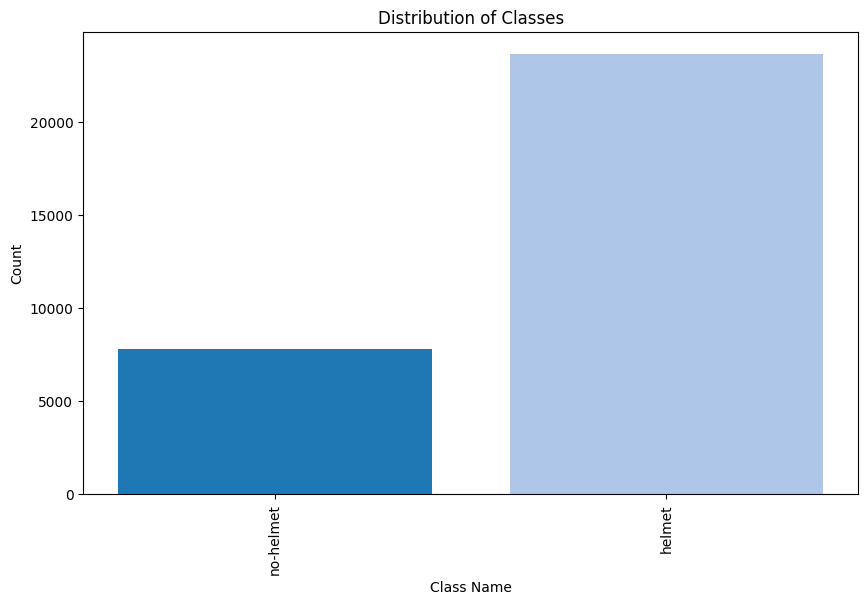

In [ ]:
def plot_class_distribution(df, use_color=True):
    plt.figure(figsize=(10, 6))  # Set the figure size

    # Create a vertical bar plot
    if use_color:
        plt.bar(df['Class Name'][:-1], df['Count'][:-1], color=mpl.cm.tab20.colors[:14])
    else:
        plt.bar(df['Class Name'][:-1], df['Count'][:-1])

    # Add labels and title
    plt.xlabel('Class Name')
    plt.ylabel('Count')
    plt.title('Distribution of Classes')

    # Rotate class names on the x-axis for better readability
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()

# Usage
plot_class_distribution(df, use_color=True)

# **Install BestYOLO**
Setelah men-download dataset, kita akan men-download BestYOLO. Struktur folder akan menjadi seperti ini:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
├── valid
│   ├── images
│   └── labels
└── BestYOLO
    ├── data
    ├── models
    └── utils

```

### **Clone BestYOLO Repository**

In [ ]:
# clone YOLOv5 repository
%cd /content/
!git clone https://github.com/WangRongsheng/BestYOLO.git  # clone repo
%cd BestYOLO

### **Install Requirements and Dependencies**

In [ ]:
# install dependencies as necessary
!pip install -r requirements.txt  # install dependencies (ignore errors)
import torch
from BestYOLO import utils

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# **Training Model**

## **Edit common.py**

In [ ]:
%%writefile /content/BestYOLO/models/common.py
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Common modules
"""

import ast
import contextlib
import json
import math
import platform
import warnings
import zipfile
from collections import OrderedDict, namedtuple
from copy import copy
from pathlib import Path
from urllib.parse import urlparse

import cv2
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display
from PIL import Image
from torch.cuda import amp

from utils import TryExcept
from utils.dataloaders import exif_transpose, letterbox
from utils.general import (LOGGER, ROOT, Profile, check_requirements, check_suffix, check_version, colorstr,
                           increment_path, is_notebook, make_divisible, non_max_suppression, scale_boxes, xywh2xyxy,
                           xyxy2xywh, yaml_load)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import copy_attr, smart_inference_mode


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    # Pad to 'same' shape outputs
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    # Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    # 非SPP模块使用：
    def forward_fuse(self, x):
    # SPP模块使用：
    #def forward_fuse(self, x):
        return self.act(self.conv(x))


class DWConv(Conv):
    # Depth-wise convolution
    def __init__(self, c1, c2, k=1, s=1, d=1, act=True):  # ch_in, ch_out, kernel, stride, dilation, activation
        super().__init__(c1, c2, k, s, g=math.gcd(c1, c2), d=d, act=act)


class DWConvTranspose2d(nn.ConvTranspose2d):
    # Depth-wise transpose convolution
    def __init__(self, c1, c2, k=1, s=1, p1=0, p2=0):  # ch_in, ch_out, kernel, stride, padding, padding_out
        super().__init__(c1, c2, k, s, p1, p2, groups=math.gcd(c1, c2))


class TransformerLayer(nn.Module):
    # Transformer layer https://arxiv.org/abs/2010.11929 (LayerNorm layers removed for better performance)
    def __init__(self, c, num_heads):
        super().__init__()
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.ma = nn.MultiheadAttention(embed_dim=c, num_heads=num_heads)
        self.fc1 = nn.Linear(c, c, bias=False)
        self.fc2 = nn.Linear(c, c, bias=False)

    def forward(self, x):
        x = self.ma(self.q(x), self.k(x), self.v(x))[0] + x
        x = self.fc2(self.fc1(x)) + x
        return x


class TransformerBlock(nn.Module):
    # Vision Transformer https://arxiv.org/abs/2010.11929
    def __init__(self, c1, c2, num_heads, num_layers):
        super().__init__()
        self.conv = None
        if c1 != c2:
            self.conv = Conv(c1, c2)
        self.linear = nn.Linear(c2, c2)  # learnable position embedding
        self.tr = nn.Sequential(*(TransformerLayer(c2, num_heads) for _ in range(num_layers)))
        self.c2 = c2

    def forward(self, x):
        if self.conv is not None:
            x = self.conv(x)
        b, _, w, h = x.shape
        p = x.flatten(2).permute(2, 0, 1)
        return self.tr(p + self.linear(p)).permute(1, 2, 0).reshape(b, self.c2, w, h)


class Bottleneck(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_, c2, 3, 1, g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class BottleneckCSP(nn.Module):
    # CSP Bottleneck https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = nn.Conv2d(c1, c_, 1, 1, bias=False)
        self.cv3 = nn.Conv2d(c_, c_, 1, 1, bias=False)
        self.cv4 = Conv(2 * c_, c2, 1, 1)
        self.bn = nn.BatchNorm2d(2 * c_)  # applied to cat(cv2, cv3)
        self.act = nn.SiLU()
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        y1 = self.cv3(self.m(self.cv1(x)))
        y2 = self.cv2(x)
        return self.cv4(self.act(self.bn(torch.cat((y1, y2), 1))))


class CrossConv(nn.Module):
    # Cross Convolution Downsample
    def __init__(self, c1, c2, k=3, s=1, g=1, e=1.0, shortcut=False):
        # ch_in, ch_out, kernel, stride, groups, expansion, shortcut
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, (1, k), (1, s))
        self.cv2 = Conv(c_, c2, (k, 1), (s, 1), g=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))


class C3(nn.Module):
    # CSP Bottleneck with 3 convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, number, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(2 * c_, c2, 1)  # optional act=FReLU(c2)
        self.m = nn.Sequential(*(Bottleneck(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

    def forward(self, x):
        return self.cv3(torch.cat((self.m(self.cv1(x)), self.cv2(x)), 1))


class C3x(C3):
    # C3 module with cross-convolutions
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = nn.Sequential(*(CrossConv(c_, c_, 3, 1, g, 1.0, shortcut) for _ in range(n)))


class C3TR(C3):
    # C3 module with TransformerBlock()
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = TransformerBlock(c_, c_, 4, n)


class C3SPP(C3):
    # C3 module with SPP()
    def __init__(self, c1, c2, k=(5, 9, 13), n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = SPP(c_, c_, k)


class C3Ghost(C3):
    # C3 module with GhostBottleneck()
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)  # hidden channels
        self.m = nn.Sequential(*(GhostBottleneck(c_, c_) for _ in range(n)))


class SPP(nn.Module):
    # Spatial Pyramid Pooling (SPP) layer https://arxiv.org/abs/1406.4729
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))


class SPPF(nn.Module):
    # Spatial Pyramid Pooling - Fast (SPPF) layer for YOLOv5 by Glenn Jocher
    def __init__(self, c1, c2, k=5):  # equivalent to SPP(k=(5, 9, 13))
        super().__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * 4, c2, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')  # suppress torch 1.9.0 max_pool2d() warning
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat((x, y1, y2, self.m(y2)), 1))


class Focus(nn.Module):
    # Focus wh information into c-space
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        self.conv = Conv(c1 * 4, c2, k, s, p, g, act=act)
        # self.contract = Contract(gain=2)

    def forward(self, x):  # x(b,c,w,h) -> y(b,4c,w/2,h/2)
        return self.conv(torch.cat((x[..., ::2, ::2], x[..., 1::2, ::2], x[..., ::2, 1::2], x[..., 1::2, 1::2]), 1))
        # return self.conv(self.contract(x))


class GhostConv(nn.Module):
    # Ghost Convolution https://github.com/huawei-noah/ghostnet
    def __init__(self, c1, c2, k=1, s=1, g=1, act=True):  # ch_in, ch_out, kernel, stride, groups
        super().__init__()
        c_ = c2 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
        self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)

    def forward(self, x):
        y = self.cv1(x)
        return torch.cat((y, self.cv2(y)), 1)


class GhostBottleneck(nn.Module):
    # Ghost Bottleneck https://github.com/huawei-noah/ghostnet
    def __init__(self, c1, c2, k=3, s=1):  # ch_in, ch_out, kernel, stride
        super().__init__()
        c_ = c2 // 2
        self.conv = nn.Sequential(
            GhostConv(c1, c_, 1, 1),  # pw
            DWConv(c_, c_, k, s, act=False) if s == 2 else nn.Identity(),  # dw
            GhostConv(c_, c2, 1, 1, act=False))  # pw-linear
        self.shortcut = nn.Sequential(DWConv(c1, c1, k, s, act=False), Conv(c1, c2, 1, 1,
                                                                            act=False)) if s == 2 else nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.shortcut(x)


class Contract(nn.Module):
    # Contract width-height into channels, i.e. x(1,64,80,80) to x(1,256,40,40)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert (h / s == 0) and (W / s == 0), 'Indivisible gain'
        s = self.gain
        x = x.view(b, c, h // s, s, w // s, s)  # x(1,64,40,2,40,2)
        x = x.permute(0, 3, 5, 1, 2, 4).contiguous()  # x(1,2,2,64,40,40)
        return x.view(b, c * s * s, h // s, w // s)  # x(1,256,40,40)


class Expand(nn.Module):
    # Expand channels into width-height, i.e. x(1,64,80,80) to x(1,16,160,160)
    def __init__(self, gain=2):
        super().__init__()
        self.gain = gain

    def forward(self, x):
        b, c, h, w = x.size()  # assert C / s ** 2 == 0, 'Indivisible gain'
        s = self.gain
        x = x.view(b, s, s, c // s ** 2, h, w)  # x(1,2,2,16,80,80)
        x = x.permute(0, 3, 4, 1, 5, 2).contiguous()  # x(1,16,80,2,80,2)
        return x.view(b, c // s ** 2, h * s, w * s)  # x(1,16,160,160)


class Concat(nn.Module):
    # Concatenate a list of tensors along dimension
    def __init__(self, dimension=1):
        super().__init__()
        self.d = dimension

    def forward(self, x):
        return torch.cat(x, self.d)


class DetectMultiBackend(nn.Module):
    # YOLOv5 MultiBackend class for python inference on various backends
    def __init__(self, weights='yolov5n.pt', device=torch.device('cpu'), dnn=False, data=None, fp16=False, fuse=True):
        # Usage:
        #   PyTorch:              weights = *.pt
        #   TorchScript:                    *.torchscript
        #   ONNX Runtime:                   *.onnx
        #   ONNX OpenCV DNN:                *.onnx --dnn
        #   OpenVINO:                       *_openvino_model
        #   CoreML:                         *.mlmodel
        #   TensorRT:                       *.engine
        #   TensorFlow SavedModel:          *_saved_model
        #   TensorFlow GraphDef:            *.pb
        #   TensorFlow Lite:                *.tflite
        #   TensorFlow Edge TPU:            *_edgetpu.tflite
        #   PaddlePaddle:                   *_paddle_model
        from models.experimental import attempt_download, attempt_load  # scoped to avoid circular import

        super().__init__()
        w = str(weights[0] if isinstance(weights, list) else weights)
        pt, jit, onnx, xml, engine, coreml, saved_model, pb, tflite, edgetpu, tfjs, paddle, triton = self._model_type(w)
        fp16 &= pt or jit or onnx or engine  # FP16
        nhwc = coreml or saved_model or pb or tflite or edgetpu  # BHWC formats (vs torch BCWH)
        stride = 32  # default stride
        cuda = torch.cuda.is_available() and device.type != 'cpu'  # use CUDA
        if not (pt or triton):
            w = attempt_download(w)  # download if not local

        if pt:  # PyTorch
            model = attempt_load(weights if isinstance(weights, list) else w, device=device, inplace=True, fuse=fuse)
            stride = max(int(model.stride.max()), 32)  # model stride
            names = model.module.names if hasattr(model, 'module') else model.names  # get class names
            model.half() if fp16 else model.float()
            self.model = model  # explicitly assign for to(), cpu(), cuda(), half()
        elif jit:  # TorchScript
            LOGGER.info(f'Loading {w} for TorchScript inference...')
            extra_files = {'config.txt': ''}  # model metadata
            model = torch.jit.load(w, _extra_files=extra_files, map_location=device)
            model.half() if fp16 else model.float()
            if extra_files['config.txt']:  # load metadata dict
                d = json.loads(extra_files['config.txt'],
                               object_hook=lambda d: {int(k) if k.isdigit() else k: v
                                                      for k, v in d.items()})
                stride, names = int(d['stride']), d['names']
        elif dnn:  # ONNX OpenCV DNN
            LOGGER.info(f'Loading {w} for ONNX OpenCV DNN inference...')
            check_requirements('opencv-python>=4.5.4')
            net = cv2.dnn.readNetFromONNX(w)
        elif onnx:  # ONNX Runtime
            LOGGER.info(f'Loading {w} for ONNX Runtime inference...')
            check_requirements(('onnx', 'onnxruntime-gpu' if cuda else 'onnxruntime'))
            import onnxruntime
            providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
            session = onnxruntime.InferenceSession(w, providers=providers)
            output_names = [x.name for x in session.get_outputs()]
            meta = session.get_modelmeta().custom_metadata_map  # metadata
            if 'stride' in meta:
                stride, names = int(meta['stride']), eval(meta['names'])
        elif xml:  # OpenVINO
            LOGGER.info(f'Loading {w} for OpenVINO inference...')
            check_requirements('openvino')  # requires openvino-dev: https://pypi.org/project/openvino-dev/
            from openvino.runtime import Core, Layout, get_batch
            ie = Core()
            if not Path(w).is_file():  # if not *.xml
                w = next(Path(w).glob('*.xml'))  # get *.xml file from *_openvino_model dir
            network = ie.read_model(model=w, weights=Path(w).with_suffix('.bin'))
            if network.get_parameters()[0].get_layout().empty:
                network.get_parameters()[0].set_layout(Layout("NCHW"))
            batch_dim = get_batch(network)
            if batch_dim.is_static:
                batch_size = batch_dim.get_length()
            executable_network = ie.compile_model(network, device_name="CPU")  # device_name="MYRIAD" for Intel NCS2
            stride, names = self._load_metadata(Path(w).with_suffix('.yaml'))  # load metadata
        elif engine:  # TensorRT
            LOGGER.info(f'Loading {w} for TensorRT inference...')
            import tensorrt as trt  # https://developer.nvidia.com/nvidia-tensorrt-download
            check_version(trt.__version__, '7.0.0', hard=True)  # require tensorrt>=7.0.0
            if device.type == 'cpu':
                device = torch.device('cuda:0')
            Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
            logger = trt.Logger(trt.Logger.INFO)
            with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
                model = runtime.deserialize_cuda_engine(f.read())
            context = model.create_execution_context()
            bindings = OrderedDict()
            output_names = []
            fp16 = False  # default updated below
            dynamic = False
            for i in range(model.num_bindings):
                name = model.get_binding_name(i)
                dtype = trt.nptype(model.get_binding_dtype(i))
                if model.binding_is_input(i):
                    if -1 in tuple(model.get_binding_shape(i)):  # dynamic
                        dynamic = True
                        context.set_binding_shape(i, tuple(model.get_profile_shape(0, i)[2]))
                    if dtype == np.float16:
                        fp16 = True
                else:  # output
                    output_names.append(name)
                shape = tuple(context.get_binding_shape(i))
                im = torch.from_numpy(np.empty(shape, dtype=dtype)).to(device)
                bindings[name] = Binding(name, dtype, shape, im, int(im.data_ptr()))
            binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
            batch_size = bindings['images'].shape[0]  # if dynamic, this is instead max batch size
        elif coreml:  # CoreML
            LOGGER.info(f'Loading {w} for CoreML inference...')
            import coremltools as ct
            model = ct.models.MLModel(w)
        elif saved_model:  # TF SavedModel
            LOGGER.info(f'Loading {w} for TensorFlow SavedModel inference...')
            import tensorflow as tf
            keras = False  # assume TF1 saved_model
            model = tf.keras.models.load_model(w) if keras else tf.saved_model.load(w)
        elif pb:  # GraphDef https://www.tensorflow.org/guide/migrate#a_graphpb_or_graphpbtxt
            LOGGER.info(f'Loading {w} for TensorFlow GraphDef inference...')
            import tensorflow as tf

            def wrap_frozen_graph(gd, inputs, outputs):
                x = tf.compat.v1.wrap_function(lambda: tf.compat.v1.import_graph_def(gd, name=""), [])  # wrapped
                ge = x.graph.as_graph_element
                return x.prune(tf.nest.map_structure(ge, inputs), tf.nest.map_structure(ge, outputs))

            def gd_outputs(gd):
                name_list, input_list = [], []
                for node in gd.node:  # tensorflow.core.framework.node_def_pb2.NodeDef
                    name_list.append(node.name)
                    input_list.extend(node.input)
                return sorted(f'{x}:0' for x in list(set(name_list) - set(input_list)) if not x.startswith('NoOp'))

            gd = tf.Graph().as_graph_def()  # TF GraphDef
            with open(w, 'rb') as f:
                gd.ParseFromString(f.read())
            frozen_func = wrap_frozen_graph(gd, inputs="x:0", outputs=gd_outputs(gd))
        elif tflite or edgetpu:  # https://www.tensorflow.org/lite/guide/python#install_tensorflow_lite_for_python
            try:  # https://coral.ai/docs/edgetpu/tflite-python/#update-existing-tf-lite-code-for-the-edge-tpu
                from tflite_runtime.interpreter import Interpreter, load_delegate
            except ImportError:
                import tensorflow as tf
                Interpreter, load_delegate = tf.lite.Interpreter, tf.lite.experimental.load_delegate,
            if edgetpu:  # TF Edge TPU https://coral.ai/software/#edgetpu-runtime
                LOGGER.info(f'Loading {w} for TensorFlow Lite Edge TPU inference...')
                delegate = {
                    'Linux': 'libedgetpu.so.1',
                    'Darwin': 'libedgetpu.1.dylib',
                    'Windows': 'edgetpu.dll'}[platform.system()]
                interpreter = Interpreter(model_path=w, experimental_delegates=[load_delegate(delegate)])
            else:  # TFLite
                LOGGER.info(f'Loading {w} for TensorFlow Lite inference...')
                interpreter = Interpreter(model_path=w)  # load TFLite model
            interpreter.allocate_tensors()  # allocate
            input_details = interpreter.get_input_details()  # inputs
            output_details = interpreter.get_output_details()  # outputs
            # load metadata
            with contextlib.suppress(zipfile.BadZipFile):
                with zipfile.ZipFile(w, "r") as model:
                    meta_file = model.namelist()[0]
                    meta = ast.literal_eval(model.read(meta_file).decode("utf-8"))
                    stride, names = int(meta['stride']), meta['names']
        elif tfjs:  # TF.js
            raise NotImplementedError('ERROR: YOLOv5 TF.js inference is not supported')
        elif paddle:  # PaddlePaddle
            LOGGER.info(f'Loading {w} for PaddlePaddle inference...')
            check_requirements('paddlepaddle-gpu' if cuda else 'paddlepaddle')
            import paddle.inference as pdi
            if not Path(w).is_file():  # if not *.pdmodel
                w = next(Path(w).rglob('*.pdmodel'))  # get *.pdmodel file from *_paddle_model dir
            weights = Path(w).with_suffix('.pdiparams')
            config = pdi.Config(str(w), str(weights))
            if cuda:
                config.enable_use_gpu(memory_pool_init_size_mb=2048, device_id=0)
            predictor = pdi.create_predictor(config)
            input_handle = predictor.get_input_handle(predictor.get_input_names()[0])
            output_names = predictor.get_output_names()
        elif triton:  # NVIDIA Triton Inference Server
            LOGGER.info(f'Using {w} as Triton Inference Server...')
            check_requirements('tritonclient[all]')
            from utils.triton import TritonRemoteModel
            model = TritonRemoteModel(url=w)
            nhwc = model.runtime.startswith("tensorflow")
        else:
            raise NotImplementedError(f'ERROR: {w} is not a supported format')

        # class names
        if 'names' not in locals():
            names = yaml_load(data)['names'] if data else {i: f'class{i}' for i in range(999)}
        if names[0] == 'n01440764' and len(names) == 1000:  # ImageNet
            names = yaml_load(ROOT / 'data/ImageNet.yaml')['names']  # human-readable names

        self.__dict__.update(locals())  # assign all variables to self

    def forward(self, im, augment=False, visualize=False):
        # YOLOv5 MultiBackend inference
        b, ch, h, w = im.shape  # batch, channel, height, width
        if self.fp16 and im.dtype != torch.float16:
            im = im.half()  # to FP16
        if self.nhwc:
            im = im.permute(0, 2, 3, 1)  # torch BCHW to numpy BHWC shape(1,320,192,3)

        if self.pt:  # PyTorch
            y = self.model(im, augment=augment, visualize=visualize) if augment or visualize else self.model(im)
        elif self.jit:  # TorchScript
            y = self.model(im)
        elif self.dnn:  # ONNX OpenCV DNN
            im = im.cpu().numpy()  # torch to numpy
            self.net.setInput(im)
            y = self.net.forward()
        elif self.onnx:  # ONNX Runtime
            im = im.cpu().numpy()  # torch to numpy
            y = self.session.run(self.output_names, {self.session.get_inputs()[0].name: im})
        elif self.xml:  # OpenVINO
            im = im.cpu().numpy()  # FP32
            y = list(self.executable_network([im]).values())
        elif self.engine:  # TensorRT
            if self.dynamic and im.shape != self.bindings['images'].shape:
                i = self.model.get_binding_index('images')
                self.context.set_binding_shape(i, im.shape)  # reshape if dynamic
                self.bindings['images'] = self.bindings['images']._replace(shape=im.shape)
                for name in self.output_names:
                    i = self.model.get_binding_index(name)
                    self.bindings[name].data.resize_(tuple(self.context.get_binding_shape(i)))
            s = self.bindings['images'].shape
            assert im.shape == s, f"input size {im.shape} {'>' if self.dynamic else 'not equal to'} max model size {s}"
            self.binding_addrs['images'] = int(im.data_ptr())
            self.context.execute_v2(list(self.binding_addrs.values()))
            y = [self.bindings[x].data for x in sorted(self.output_names)]
        elif self.coreml:  # CoreML
            im = im.cpu().numpy()
            im = Image.fromarray((im[0] * 255).astype('uint8'))
            # im = im.resize((192, 320), Image.ANTIALIAS)
            y = self.model.predict({'image': im})  # coordinates are xywh normalized
            if 'confidence' in y:
                box = xywh2xyxy(y['coordinates'] * [[w, h, w, h]])  # xyxy pixels
                conf, cls = y['confidence'].max(1), y['confidence'].argmax(1).astype(np.float)
                y = np.concatenate((box, conf.reshape(-1, 1), cls.reshape(-1, 1)), 1)
            else:
                y = list(reversed(y.values()))  # reversed for segmentation models (pred, proto)
        elif self.paddle:  # PaddlePaddle
            im = im.cpu().numpy().astype(np.float32)
            self.input_handle.copy_from_cpu(im)
            self.predictor.run()
            y = [self.predictor.get_output_handle(x).copy_to_cpu() for x in self.output_names]
        elif self.triton:  # NVIDIA Triton Inference Server
            y = self.model(im)
        else:  # TensorFlow (SavedModel, GraphDef, Lite, Edge TPU)
            im = im.cpu().numpy()
            if self.saved_model:  # SavedModel
                y = self.model(im, training=False) if self.keras else self.model(im)
            elif self.pb:  # GraphDef
                y = self.frozen_func(x=self.tf.constant(im))
            else:  # Lite or Edge TPU
                input = self.input_details[0]
                int8 = input['dtype'] == np.uint8  # is TFLite quantized uint8 model
                if int8:
                    scale, zero_point = input['quantization']
                    im = (im / scale + zero_point).astype(np.uint8)  # de-scale
                self.interpreter.set_tensor(input['index'], im)
                self.interpreter.invoke()
                y = []
                for output in self.output_details:
                    x = self.interpreter.get_tensor(output['index'])
                    if int8:
                        scale, zero_point = output['quantization']
                        x = (x.astype(np.float32) - zero_point) * scale  # re-scale
                    y.append(x)
            y = [x if isinstance(x, np.ndarray) else x.numpy() for x in y]
            y[0][..., :4] *= [w, h, w, h]  # xywh normalized to pixels

        if isinstance(y, (list, tuple)):
            return self.from_numpy(y[0]) if len(y) == 1 else [self.from_numpy(x) for x in y]
        else:
            return self.from_numpy(y)

    def from_numpy(self, x):
        return torch.from_numpy(x).to(self.device) if isinstance(x, np.ndarray) else x

    def warmup(self, imgsz=(1, 3, 640, 640)):
        # Warmup model by running inference once
        warmup_types = self.pt, self.jit, self.onnx, self.engine, self.saved_model, self.pb, self.triton
        if any(warmup_types) and (self.device.type != 'cpu' or self.triton):
            im = torch.empty(*imgsz, dtype=torch.half if self.fp16 else torch.float, device=self.device)  # input
            for _ in range(2 if self.jit else 1):  #
                self.forward(im)  # warmup

    @staticmethod
    def _model_type(p='path/to/model.pt'):
        # Return model type from model path, i.e. path='path/to/model.onnx' -> type=onnx
        # types = [pt, jit, onnx, xml, engine, coreml, saved_model, pb, tflite, edgetpu, tfjs, paddle]
        from export import export_formats
        from utils.downloads import is_url
        sf = list(export_formats().Suffix)  # export suffixes
        if not is_url(p, check=False):
            check_suffix(p, sf)  # checks
        url = urlparse(p)  # if url may be Triton inference server
        types = [s in Path(p).name for s in sf]
        types[8] &= not types[9]  # tflite &= not edgetpu
        triton = not any(types) and all([any(s in url.scheme for s in ["http", "grpc"]), url.netloc])
        return types + [triton]

    @staticmethod
    def _load_metadata(f=Path('path/to/meta.yaml')):
        # Load metadata from meta.yaml if it exists
        if f.exists():
            d = yaml_load(f)
            return d['stride'], d['names']  # assign stride, names
        return None, None


class AutoShape(nn.Module):
    # YOLOv5 input-robust model wrapper for passing cv2/np/PIL/torch inputs. Includes preprocessing, inference and NMS
    conf = 0.25  # NMS confidence threshold
    iou = 0.45  # NMS IoU threshold
    agnostic = False  # NMS class-agnostic
    multi_label = False  # NMS multiple labels per box
    classes = None  # (optional list) filter by class, i.e. = [0, 15, 16] for COCO persons, cats and dogs
    max_det = 1000  # maximum number of detections per image
    amp = False  # Automatic Mixed Precision (AMP) inference

    def __init__(self, model, verbose=True):
        super().__init__()
        if verbose:
            LOGGER.info('Adding AutoShape... ')
        copy_attr(self, model, include=('yaml', 'nc', 'hyp', 'names', 'stride', 'abc'), exclude=())  # copy attributes
        self.dmb = isinstance(model, DetectMultiBackend)  # DetectMultiBackend() instance
        self.pt = not self.dmb or model.pt  # PyTorch model
        self.model = model.eval()
        if self.pt:
            m = self.model.model.model[-1] if self.dmb else self.model.model[-1]  # Detect()
            m.inplace = False  # Detect.inplace=False for safe multithread inference
            m.export = True  # do not output loss values

    def _apply(self, fn):
        # Apply to(), cpu(), cuda(), half() to model tensors that are not parameters or registered buffers
        self = super()._apply(fn)
        if self.pt:
            m = self.model.model.model[-1] if self.dmb else self.model.model[-1]  # Detect()
            m.stride = fn(m.stride)
            m.grid = list(map(fn, m.grid))
            if isinstance(m.anchor_grid, list):
                m.anchor_grid = list(map(fn, m.anchor_grid))
        return self

    @smart_inference_mode()
    def forward(self, ims, size=640, augment=False, profile=False):
        # Inference from various sources. For size(height=640, width=1280), RGB images example inputs are:
        #   file:        ims = 'data/images/zidane.jpg'  # str or PosixPath
        #   URI:             = 'https://ultralytics.com/images/zidane.jpg'
        #   OpenCV:          = cv2.imread('image.jpg')[:,:,::-1]  # HWC BGR to RGB x(640,1280,3)
        #   PIL:             = Image.open('image.jpg') or ImageGrab.grab()  # HWC x(640,1280,3)
        #   numpy:           = np.zeros((640,1280,3))  # HWC
        #   torch:           = torch.zeros(16,3,320,640)  # BCHW (scaled to size=640, 0-1 values)
        #   multiple:        = [Image.open('image1.jpg'), Image.open('image2.jpg'), ...]  # list of images

        dt = (Profile(), Profile(), Profile())
        with dt[0]:
            if isinstance(size, int):  # expand
                size = (size, size)
            p = next(self.model.parameters()) if self.pt else torch.empty(1, device=self.model.device)  # param
            autocast = self.amp and (p.device.type != 'cpu')  # Automatic Mixed Precision (AMP) inference
            if isinstance(ims, torch.Tensor):  # torch
                with amp.autocast(autocast):
                    return self.model(ims.to(p.device).type_as(p), augment=augment)  # inference

            # Pre-process
            n, ims = (len(ims), list(ims)) if isinstance(ims, (list, tuple)) else (1, [ims])  # number, list of images
            shape0, shape1, files = [], [], []  # image and inference shapes, filenames
            for i, im in enumerate(ims):
                f = f'image{i}'  # filename
                if isinstance(im, (str, Path)):  # filename or uri
                    im, f = Image.open(requests.get(im, stream=True).raw if str(im).startswith('http') else im), im
                    im = np.asarray(exif_transpose(im))
                elif isinstance(im, Image.Image):  # PIL Image
                    im, f = np.asarray(exif_transpose(im)), getattr(im, 'filename', f) or f
                files.append(Path(f).with_suffix('.jpg').name)
                if im.shape[0] < 5:  # image in CHW
                    im = im.transpose((1, 2, 0))  # reverse dataloader .transpose(2, 0, 1)
                im = im[..., :3] if im.ndim == 3 else cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)  # enforce 3ch input
                s = im.shape[:2]  # HWC
                shape0.append(s)  # image shape
                g = max(size) / max(s)  # gain
                shape1.append([int(y * g) for y in s])
                ims[i] = im if im.data.contiguous else np.ascontiguousarray(im)  # update
            shape1 = [make_divisible(x, self.stride) for x in np.array(shape1).max(0)]  # inf shape
            x = [letterbox(im, shape1, auto=False)[0] for im in ims]  # pad
            x = np.ascontiguousarray(np.array(x).transpose((0, 3, 1, 2)))  # stack and BHWC to BCHW
            x = torch.from_numpy(x).to(p.device).type_as(p) / 255  # uint8 to fp16/32

        with amp.autocast(autocast):
            # Inference
            with dt[1]:
                y = self.model(x, augment=augment)  # forward

            # Post-process
            with dt[2]:
                y = non_max_suppression(y if self.dmb else y[0],
                                        self.conf,
                                        self.iou,
                                        self.classes,
                                        self.agnostic,
                                        self.multi_label,
                                        max_det=self.max_det)  # NMS
                for i in range(n):
                    scale_boxes(shape1, y[i][:, :4], shape0[i])

            return Detections(ims, y, files, dt, self.names, x.shape)


class Detections:
    # YOLOv5 detections class for inference results
    def __init__(self, ims, pred, files, times=(0, 0, 0), names=None, shape=None):
        super().__init__()
        d = pred[0].device  # device
        gn = [torch.tensor([*(im.shape[i] for i in [1, 0, 1, 0]), 1, 1], device=d) for im in ims]  # normalizations
        self.ims = ims  # list of images as numpy arrays
        self.pred = pred  # list of tensors pred[0] = (xyxy, conf, cls)
        self.names = names  # class names
        self.files = files  # image filenames
        self.times = times  # profiling times
        self.xyxy = pred  # xyxy pixels
        self.xywh = [xyxy2xywh(x) for x in pred]  # xywh pixels
        self.xyxyn = [x / g for x, g in zip(self.xyxy, gn)]  # xyxy normalized
        self.xywhn = [x / g for x, g in zip(self.xywh, gn)]  # xywh normalized
        self.n = len(self.pred)  # number of images (batch size)
        self.t = tuple(x.t / self.n * 1E3 for x in times)  # timestamps (ms)
        self.s = tuple(shape)  # inference BCHW shape

    def _run(self, pprint=False, show=False, save=False, crop=False, render=False, labels=True, save_dir=Path('')):
        s, crops = '', []
        for i, (im, pred) in enumerate(zip(self.ims, self.pred)):
            s += f'\nimage {i + 1}/{len(self.pred)}: {im.shape[0]}x{im.shape[1]} '  # string
            if pred.shape[0]:
                for c in pred[:, -1].unique():
                    n = (pred[:, -1] == c).sum()  # detections per class
                    s += f"{n} {self.names[int(c)]}{'s' * (n > 1)}, "  # add to string
                s = s.rstrip(', ')
                if show or save or render or crop:
                    annotator = Annotator(im, example=str(self.names))
                    for *box, conf, cls in reversed(pred):  # xyxy, confidence, class
                        label = f'{self.names[int(cls)]} {conf:.2f}'
                        if crop:
                            file = save_dir / 'crops' / self.names[int(cls)] / self.files[i] if save else None
                            crops.append({
                                'box': box,
                                'conf': conf,
                                'cls': cls,
                                'label': label,
                                'im': save_one_box(box, im, file=file, save=save)})
                        else:  # all others
                            annotator.box_label(box, label if labels else '', color=colors(cls))
                    im = annotator.im
            else:
                s += '(no detections)'

            im = Image.fromarray(im.astype(np.uint8)) if isinstance(im, np.ndarray) else im  # from np
            if show:
                display(im) if is_notebook() else im.show(self.files[i])
            if save:
                f = self.files[i]
                im.save(save_dir / f)  # save
                if i == self.n - 1:
                    LOGGER.info(f"Saved {self.n} image{'s' * (self.n > 1)} to {colorstr('bold', save_dir)}")
            if render:
                self.ims[i] = np.asarray(im)
        if pprint:
            s = s.lstrip('\n')
            return f'{s}\nSpeed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {self.s}' % self.t
        if crop:
            if save:
                LOGGER.info(f'Saved results to {save_dir}\n')
            return crops

    @TryExcept('Showing images is not supported in this environment')
    def show(self, labels=True):
        self._run(show=True, labels=labels)  # show results

    def save(self, labels=True, save_dir='runs/detect/exp', exist_ok=False):
        save_dir = increment_path(save_dir, exist_ok, mkdir=True)  # increment save_dir
        self._run(save=True, labels=labels, save_dir=save_dir)  # save results

    def crop(self, save=True, save_dir='runs/detect/exp', exist_ok=False):
        save_dir = increment_path(save_dir, exist_ok, mkdir=True) if save else None
        return self._run(crop=True, save=save, save_dir=save_dir)  # crop results

    def render(self, labels=True):
        self._run(render=True, labels=labels)  # render results
        return self.ims

    def pandas(self):
        # return detections as pandas DataFrames, i.e. print(results.pandas().xyxy[0])
        new = copy(self)  # return copy
        ca = 'xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class', 'name'  # xyxy columns
        cb = 'xcenter', 'ycenter', 'width', 'height', 'confidence', 'class', 'name'  # xywh columns
        for k, c in zip(['xyxy', 'xyxyn', 'xywh', 'xywhn'], [ca, ca, cb, cb]):
            a = [[x[:5] + [int(x[5]), self.names[int(x[5])]] for x in x.tolist()] for x in getattr(self, k)]  # update
            setattr(new, k, [pd.DataFrame(x, columns=c) for x in a])
        return new

    def tolist(self):
        # return a list of Detections objects, i.e. 'for result in results.tolist():'
        r = range(self.n)  # iterable
        x = [Detections([self.ims[i]], [self.pred[i]], [self.files[i]], self.times, self.names, self.s) for i in r]
        # for d in x:
        #    for k in ['ims', 'pred', 'xyxy', 'xyxyn', 'xywh', 'xywhn']:
        #        setattr(d, k, getattr(d, k)[0])  # pop out of list
        return x

    def print(self):
        LOGGER.info(self.__str__())

    def __len__(self):  # override len(results)
        return self.n

    def __str__(self):  # override print(results)
        return self._run(pprint=True)  # print results

    def __repr__(self):
        return f'YOLOv5 {self.__class__} instance\n' + self.__str__()


class Proto(nn.Module):
    # YOLOv5 mask Proto module for segmentation models
    def __init__(self, c1, c_=256, c2=32):  # ch_in, number of protos, number of masks
        super().__init__()
        self.cv1 = Conv(c1, c_, k=3)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.cv2 = Conv(c_, c_, k=3)
        self.cv3 = Conv(c_, c2)

    def forward(self, x):
        return self.cv3(self.cv2(self.upsample(self.cv1(x))))


class Classify(nn.Module):
    # YOLOv5 classification head, i.e. x(b,c1,20,20) to x(b,c2)
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()
        c_ = 1280  # efficientnet_b0 size
        self.conv = Conv(c1, c_, k, s, autopad(k, p), g)
        self.pool = nn.AdaptiveAvgPool2d(1)  # to x(b,c_,1,1)
        self.drop = nn.Dropout(p=0.0, inplace=True)
        self.linear = nn.Linear(c_, c2)  # to x(b,c2)

    def forward(self, x):
        if isinstance(x, list):
            x = torch.cat(x, 1)
        return self.linear(self.drop(self.pool(self.conv(x)).flatten(1)))

from torchvision import models
'''
模型：mobilenet_v3_small
'''
class MobileNetV3s1(nn.Module):
    # out channel 24
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v3_small(pretrained=True)
        modules = list(model.children())
        modules = modules[0][:4]
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

class MobileNetV3s2(nn.Module):
    # out 48 channel
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v3_small(pretrained=True)
        modules = list(model.children())
        modules = modules[0][4:9]
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

class MobileNetV3s3(nn.Module):
    # out 576 channel
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v3_small(pretrained=True)
        modules = list(model.children())
        modules = modules[0][9:]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：efficientnet_b0
'''
class efficientnet_b01(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b0()
        modules = list(model.children())
        modules = modules[0][:4]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_b02(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b0()
        modules = list(model.children())
        modules = modules[0][4:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_b03(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b0()
        modules = list(model.children())
        modules = modules[0][6:]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：RegNety400
'''
class RegNety4001(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.regnet_y_400mf()
        modules = list(model.children())
        self.model = nn.Sequential(modules[0], *modules[1][:2])

    def forward(self, x):
        return self.model(x)

class RegNety4002(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.regnet_y_400mf()
        modules = list(model.children())
        modules = modules[1][2]
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

class RegNety4003(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.regnet_y_400mf()
        modules = list(model.children())
        modules = modules[1][3]
        self.model = nn.Sequential(*modules)

    def forward(self, x):
        return self.model(x)

'''
模型：resnet18
'''
class resnet181(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet18()
        modules = list(model.children())
        modules = modules[:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet182(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet18()
        modules = list(model.children())
        modules = modules[6:7]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet183(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet18()
        modules = list(model.children())
        modules = modules[7:8]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：resnet34
'''
class resnet341(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet34()
        modules = list(model.children())
        modules = modules[:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet342(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet34()
        modules = list(model.children())
        modules = modules[6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet343(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet34()
        modules = list(model.children())
        modules = modules[7]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：resnet50
'''
class resnet501(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())
        modules = modules[:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet502(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())
        modules = modules[6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class resnet503(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.resnet50(pretrained=True)
        modules = list(model.children())
        modules = modules[7]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    

'''
模型：efficientnet_v2_s
'''
class efficientnet_v2_s1(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_v2_s()
        modules = list(model.children())
        modules = modules[0][:4]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_v2_s2(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_v2_s()
        modules = list(model.children())
        modules = modules[0][4:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_v2_s3(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_v2_s()
        modules = list(model.children())
        modules = modules[0][6:]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
'''
模型：efficientnet_b1
'''
class efficientnet_b11(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b1()
        modules = list(model.children())
        modules = modules[0][:4]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_b12(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b1()
        modules = list(model.children())
        modules = modules[0][4:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class efficientnet_b13(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.efficientnet_b0()
        modules = list(model.children())
        modules = modules[0][6:]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：mobilenet_v2
'''
class mobilenet_v21(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v2()
        modules = list(model.children())
        modules = modules[0][:7]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class mobilenet_v22(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v2()
        modules = list(model.children())
        modules = modules[0][7:14]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class mobilenet_v23(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.mobilenet_v2()
        modules = list(model.children())
        modules = modules[0][14:19]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：wide_resnet50_2
'''
class wide_resnet50_21(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.wide_resnet50_2()
        modules = list(model.children())
        modules = modules[:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class wide_resnet50_22(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.wide_resnet50_2()
        modules = list(model.children())
        modules = modules[6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class wide_resnet50_23(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.wide_resnet50_2()
        modules = list(model.children())
        modules = modules[7]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：vgg11_bn
'''
class vgg11_bn1(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.vgg11_bn()
        modules = list(model.children())
        modules = modules[0][:14]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class vgg11_bn2(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.vgg11_bn()
        modules = list(model.children())
        modules = modules[0][14:21]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class vgg11_bn3(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.vgg11_bn()
        modules = list(model.children())
        modules = modules[0][21:28]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
模型：convnext_tiny
'''
class convnext_tiny1(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.convnext_tiny()
        modules = list(model.children())
        modules = modules[0][:4]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class convnext_tiny2(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.convnext_tiny()
        modules = list(model.children())
        modules = modules[0][4:6]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)
    
class convnext_tiny3(nn.Module):
    def __init__(self, ignore) -> None:
        super().__init__()
        model = models.convnext_tiny()
        modules = list(model.children())
        modules = modules[0][6:8]
        self.model = nn.Sequential(*modules)
    def forward(self, x):
        return self.model(x)

'''
SPP
# 使用此方法请将：找到common.py 中的 Conv 类，将 foward_fuse 方法改成 fuseforward
'''
class SPP(nn.Module):
    # Spatial pyramid pooling layer used in YOLOv3-SPP
    def __init__(self, c1, c2, k=(5, 9, 13)):
        super(SPP, self).__init__()
        c_ = c1 // 2  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c_ * (len(k) + 1), c2, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])

    def forward(self, x):
        x = self.cv1(x)
        return self.cv2(torch.cat([x] + [m(x) for m in self.m], 1))


'''
SimSPPF
'''
class SimConv(nn.Module):
    '''Normal Conv with ReLU activation'''
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1, bias=False):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=groups,
            bias=bias,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))

class SimSPPF(nn.Module):
    '''Simplified SPPF with ReLU activation'''
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        c_ = in_channels // 2  # hidden channels
        self.cv1 = SimConv(in_channels, c_, 1, 1)
        self.cv2 = SimConv(c_ * 4, out_channels, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        x = self.cv1(x)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            y1 = self.m(x)
            y2 = self.m(y1)
            return self.cv2(torch.cat([x, y1, y2, self.m(y2)], 1))

'''
ASPP
'''
# without BN version
class ASPP(nn.Module):
    def __init__(self, in_channel=512, out_channel=256):
        super(ASPP, self).__init__()
        self.mean = nn.AdaptiveAvgPool2d((1, 1))  # (1,1)means ouput_dim
        self.conv = nn.Conv2d(in_channel,out_channel, 1, 1)
        self.atrous_block1 = nn.Conv2d(in_channel, out_channel, 1, 1)
        self.atrous_block6 = nn.Conv2d(in_channel, out_channel, 3, 1, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channel, out_channel, 3, 1, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channel, out_channel, 3, 1, padding=18, dilation=18)
        self.conv_1x1_output = nn.Conv2d(out_channel * 5, out_channel, 1, 1)

    def forward(self, x):
        size = x.shape[2:]

        image_features = self.mean(x)
        image_features = self.conv(image_features)
        image_features = F.upsample(image_features, size=size, mode='bilinear')

        atrous_block1 = self.atrous_block1(x)
        atrous_block6 = self.atrous_block6(x)
        atrous_block12 = self.atrous_block12(x)
        atrous_block18 = self.atrous_block18(x)

        net = self.conv_1x1_output(torch.cat([image_features, atrous_block1, atrous_block6,
                                              atrous_block12, atrous_block18], dim=1))
        return net

'''
RFB
'''
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        if bn:
            self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=False)
            self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True)
            self.relu = nn.ReLU(inplace=True) if relu else None
        else:
            self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=True)
            self.bn = None
            self.relu = nn.ReLU(inplace=True) if relu else None
    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class RFB(nn.Module):
    def __init__(self, in_planes, out_planes, stride=1, scale=0.1, map_reduce=8, vision=1, groups=1):
        super(RFB, self).__init__()
        self.scale = scale
        self.out_channels = out_planes
        inter_planes = in_planes // map_reduce

        self.branch0 = nn.Sequential(
            BasicConv(in_planes, inter_planes, kernel_size=1, stride=1, groups=groups, relu=False),
            BasicConv(inter_planes, 2 * inter_planes, kernel_size=(3, 3), stride=stride, padding=(1, 1), groups=groups),
            BasicConv(2 * inter_planes, 2 * inter_planes, kernel_size=3, stride=1, padding=vision + 1, dilation=vision + 1, relu=False, groups=groups)
        )
        self.branch1 = nn.Sequential(
            BasicConv(in_planes, inter_planes, kernel_size=1, stride=1, groups=groups, relu=False),
            BasicConv(inter_planes, 2 * inter_planes, kernel_size=(3, 3), stride=stride, padding=(1, 1), groups=groups),
            BasicConv(2 * inter_planes, 2 * inter_planes, kernel_size=3, stride=1, padding=vision + 2, dilation=vision + 2, relu=False, groups=groups)
        )
        self.branch2 = nn.Sequential(
            BasicConv(in_planes, inter_planes, kernel_size=1, stride=1, groups=groups, relu=False),
            BasicConv(inter_planes, (inter_planes // 2) * 3, kernel_size=3, stride=1, padding=1, groups=groups),
            BasicConv((inter_planes // 2) * 3, 2 * inter_planes, kernel_size=3, stride=stride, padding=1, groups=groups),
            BasicConv(2 * inter_planes, 2 * inter_planes, kernel_size=3, stride=1, padding=vision + 4, dilation=vision + 4, relu=False, groups=groups)
        )

        self.ConvLinear = BasicConv(6 * inter_planes, out_planes, kernel_size=1, stride=1, relu=False)
        self.shortcut = BasicConv(in_planes, out_planes, kernel_size=1, stride=stride, relu=False)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)

        out = torch.cat((x0, x1, x2), 1)
        out = self.ConvLinear(out)
        short = self.shortcut(x)
        out = out * self.scale + short
        out = self.relu(out)

        return out

'''
SPPCSPC-YOLOv7
'''
class SPPCSPC(nn.Module):
    # CSP https://github.com/WongKinYiu/CrossStagePartialNetworks
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, k=(5, 9, 13)):
        super(SPPCSPC, self).__init__()
        c_ = int(2 * c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(c_, c_, 3, 1)
        self.cv4 = Conv(c_, c_, 1, 1)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])
        self.cv5 = Conv(4 * c_, c_, 1, 1)
        self.cv6 = Conv(c_, c_, 3, 1)
        self.cv7 = Conv(2 * c_, c2, 1, 1)

    def forward(self, x):
        x1 = self.cv4(self.cv3(self.cv1(x)))
        y1 = self.cv6(self.cv5(torch.cat([x1] + [m(x1) for m in self.m], 1)))
        y2 = self.cv2(x)
        return self.cv7(torch.cat((y1, y2), dim=1))

#分组SPPCSPC 分组后参数量和计算量与原本差距不大，不知道效果怎么样
class SPPCSPC_group(nn.Module):
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, k=(5, 9, 13)):
        super(SPPCSPC_group, self).__init__()
        c_ = int(2 * c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1, g=4)
        self.cv2 = Conv(c1, c_, 1, 1, g=4)
        self.cv3 = Conv(c_, c_, 3, 1, g=4)
        self.cv4 = Conv(c_, c_, 1, 1, g=4)
        self.m = nn.ModuleList([nn.MaxPool2d(kernel_size=x, stride=1, padding=x // 2) for x in k])
        self.cv5 = Conv(4 * c_, c_, 1, 1, g=4)
        self.cv6 = Conv(c_, c_, 3, 1, g=4)
        self.cv7 = Conv(2 * c_, c2, 1, 1, g=4)

    def forward(self, x):
        x1 = self.cv4(self.cv3(self.cv1(x)))
        y1 = self.cv6(self.cv5(torch.cat([x1] + [m(x1) for m in self.m], 1)))
        y2 = self.cv2(x)
        return self.cv7(torch.cat((y1, y2), dim=1))

'''
SimCSPSPPF-YOLOv6 v0.3
'''
class SimCSPSPPF(nn.Module):
    def __init__(self, c1, c2, n=1, shortcut=False, g=1, e=0.5, k=5):
        super(SimCSPSPPF, self).__init__()
        c_ = int(2 * c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = Conv(c1, c_, 1, 1)
        self.cv3 = Conv(c_, c_, 3, 1)
        self.cv4 = Conv(c_, c_, 1, 1)
        self.m = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)
        self.cv5 = Conv(4 * c_, c_, 1, 1)
        self.cv6 = Conv(c_, c_, 3, 1)
        self.cv7 = Conv(2 * c_, c2, 1, 1)

    def forward(self, x):
        x1 = self.cv4(self.cv3(self.cv1(x)))
        x2 = self.m(x1)
        x3 = self.m(x2)
        y1 = self.cv6(self.cv5(torch.cat((x1,x2,x3, self.m(x3)),1)))
        y2 = self.cv2(x)
        return self.cv7(torch.cat((y1, y2), dim=1))

'''
为了替换卷积，在这篇文章中提出了独立自注意力层和空间感知独立自注意力层。
空间感知独立自注意力层在独立自注意力层上加了一些位置相关的信息，
在图像问题中卷积网络的初始层，也叫stem,它与其它层有比较大的区别。
一般认为初始层的功能主要有两个方面。第一，学习局部特征，如边缘，
用于后续的全局目标识别或检测。第二，由于输入图像通常比较大，初始
层的任务还有下采样。如ResNet的初始层为stride为2的7x7卷积，以及
stride为2的3x3 max pooling。初始层的输入为RGB图像，每个像素
的信息单独拿出来并不是很重要，但是它们与周围的像素有很大的空间
相关性。这种特征使得像自注意力一样的基于内容的机制很难学习到有
效的特征，如边缘。总之，卷积网络的初始层与其他层有一些功能上的
区别，而文中提出的标准自注意力机制无法满足初始层的要求。因此文中
又提出了一个空间感知(spatially aware)自注意力层来
解决标准的自注意力层无法包含空间信息的问题。
'''
class AttentionConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, groups=1, bias=False):
        super(AttentionConv, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.rel_h = nn.Parameter(torch.randn(out_channels // 2, 1, 1, kernel_size, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(out_channels // 2, 1, 1, 1, kernel_size), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])
        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = self.value_conv(padded_x)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)

        k_out_h, k_out_w = k_out.split(self.out_channels // 2, dim=1)
        k_out = torch.cat((k_out_h + self.rel_h, k_out_w + self.rel_w), dim=1)

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk -> bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        # 版本差异导致init报错的，可以在init前面加上nn.
        nn.init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')

        nn.init.normal_(self.rel_h, 0, 1)
        nn.init.normal_(self.rel_w, 0, 1)

class AttentionStem(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, groups=1, m=4, bias=False):
        super(AttentionStem, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.m = m

        assert self.out_channels % self.groups == 0, "out_channels should be divided by groups. (example: out_channels: 40, groups: 4)"

        self.emb_a = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_b = nn.Parameter(torch.randn(out_channels // groups, kernel_size), requires_grad=True)
        self.emb_mix = nn.Parameter(torch.randn(m, out_channels // groups), requires_grad=True)

        self.key_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.query_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        self.value_conv = nn.ModuleList([nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias) for _ in range(m)])

        self.reset_parameters()

    def forward(self, x):
        batch, channels, height, width = x.size()

        padded_x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        q_out = self.query_conv(x)
        k_out = self.key_conv(padded_x)
        v_out = torch.stack([self.value_conv[_](padded_x) for _ in range(self.m)], dim=0)

        k_out = k_out.unfold(2, self.kernel_size, self.stride).unfold(3, self.kernel_size, self.stride)
        v_out = v_out.unfold(3, self.kernel_size, self.stride).unfold(4, self.kernel_size, self.stride)

        k_out = k_out[:, :, :height, :width, :, :]
        v_out = v_out[:, :, :, :height, :width, :, :]

        emb_logit_a = torch.einsum('mc,ca->ma', self.emb_mix, self.emb_a)
        emb_logit_b = torch.einsum('mc,cb->mb', self.emb_mix, self.emb_b)
        emb = emb_logit_a.unsqueeze(2) + emb_logit_b.unsqueeze(1)
        emb = F.softmax(emb.view(self.m, -1), dim=0).view(self.m, 1, 1, 1, 1, self.kernel_size, self.kernel_size)

        v_out = emb * v_out

        k_out = k_out.contiguous().view(batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = v_out.contiguous().view(self.m, batch, self.groups, self.out_channels // self.groups, height, width, -1)
        v_out = torch.sum(v_out, dim=0).view(batch, self.groups, self.out_channels // self.groups, height, width, -1)

        q_out = q_out.view(batch, self.groups, self.out_channels // self.groups, height, width, 1)

        out = q_out * k_out
        out = F.softmax(out, dim=-1)
        out = torch.einsum('bnchwk,bnchwk->bnchw', out, v_out).view(batch, -1, height, width)

        return out

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        for _ in self.value_conv:
            nn.init.kaiming_normal_(_.weight, mode='fan_out', nonlinearity='relu')

        nn.init.normal_(self.emb_a, 0, 1)
        nn.init.normal_(self.emb_b, 0, 1)
        nn.init.normal_(self.emb_mix, 0, 1)

class DCNv2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=1, dilation=1, groups=1, deformable_groups=1):
        super(DCNv2, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.stride = (stride, stride)
        self.padding = (padding, padding)
        self.dilation = (dilation, dilation)
        self.groups = groups
        self.deformable_groups = deformable_groups

        self.weight = nn.Parameter(
            torch.empty(out_channels, in_channels, *self.kernel_size)
        )
        self.bias = nn.Parameter(torch.empty(out_channels))

        out_channels_offset_mask = (self.deformable_groups * 3 *
                                    self.kernel_size[0] * self.kernel_size[1])
        self.conv_offset_mask = nn.Conv2d(
            self.in_channels,
            out_channels_offset_mask,
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding,
            bias=True,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = Conv.default_act
        self.reset_parameters()

    def forward(self, x):
        offset_mask = self.conv_offset_mask(x)
        o1, o2, mask = torch.chunk(offset_mask, 3, dim=1)
        offset = torch.cat((o1, o2), dim=1)
        mask = torch.sigmoid(mask)
        x = torch.ops.torchvision.deform_conv2d(
            x,
            self.weight,
            offset,
            mask,
            self.bias,
            self.stride[0], self.stride[1],
            self.padding[0], self.padding[1],
            self.dilation[0], self.dilation[1],
            self.groups,
            self.deformable_groups,
            True
        )
        x = self.bn(x)
        x = self.act(x)
        return x

    def reset_parameters(self):
        n = self.in_channels
        for k in self.kernel_size:
            n *= k
        std = 1. / math.sqrt(n)
        self.weight.data.uniform_(-std, std)
        self.bias.data.zero_()
        self.conv_offset_mask.weight.data.zero_()
        self.conv_offset_mask.bias.data.zero_()

class Bottleneck_DCN(nn.Module):
    # Standard bottleneck
    def __init__(self, c1, c2, shortcut=True, g=1, e=0.5):  # ch_in, ch_out, shortcut, groups, expansion
        super().__init__()
        c_ = int(c2 * e)  # hidden channels
        self.cv1 = Conv(c1, c_, 1, 1)
        self.cv2 = DCNv2(c_, c2, 3, 1, groups=g)
        self.add = shortcut and c1 == c2

    def forward(self, x):
        return x + self.cv2(self.cv1(x)) if self.add else self.cv2(self.cv1(x))

class C3_DCN(C3):
    # C3 module with DCNv2
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = nn.Sequential(*(Bottleneck_DCN(c_, c_, shortcut, g, e=1.0) for _ in range(n)))

## **Edit train.py**

In [ ]:
%%writefile /content/BestYOLO/train.py
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license
"""
Train a YOLOv5 model on a custom dataset.
Models and datasets download automatically from the latest YOLOv5 release.

Usage - Single-GPU training:
    $ python train.py --data coco128.yaml --weights yolov5s.pt --img 640  # from pretrained (recommended)
    $ python train.py --data coco128.yaml --weights '' --cfg yolov5s.yaml --img 640  # from scratch

Usage - Multi-GPU DDP training:
    $ python -m torch.distributed.run --nproc_per_node 4 --master_port 1 train.py --data coco128.yaml --weights yolov5s.pt --img 640 --device 0,1,2,3

Models:     https://github.com/ultralytics/yolov5/tree/master/models
Datasets:   https://github.com/ultralytics/yolov5/tree/master/data
Tutorial:   https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
"""

import argparse
import math
import os
import random
import sys
import time
from copy import deepcopy
from datetime import datetime
from pathlib import Path

import numpy as np
import torch
import torch.distributed as dist
import torch.nn as nn
import yaml
from torch.optim import lr_scheduler
from tqdm import tqdm

FILE = Path(__file__).resolve()
ROOT = FILE.parents[0]  # YOLOv5 root directory
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))  # add ROOT to PATH
ROOT = Path(os.path.relpath(ROOT, Path.cwd()))  # relative

import val as validate  # for end-of-epoch mAP
from models.experimental import attempt_load
from models.yolo import Model
from utils.autoanchor import check_anchors
from utils.autobatch import check_train_batch_size
from utils.callbacks import Callbacks
from utils.dataloaders import create_dataloader
from utils.downloads import attempt_download, is_url
from utils.general import (LOGGER, TQDM_BAR_FORMAT, check_amp, check_dataset, check_file, check_git_info,
                           check_git_status, check_img_size, check_requirements, check_suffix, check_yaml, colorstr,
                           get_latest_run, increment_path, init_seeds, intersect_dicts, labels_to_class_weights,
                           labels_to_image_weights, methods, one_cycle, print_args, print_mutation, strip_optimizer,
                           yaml_save)
from utils.loggers import Loggers
from utils.loggers.comet.comet_utils import check_comet_resume
from utils.loss import ComputeLoss
from utils.loss_OTA import ComputeLossOTA
from utils.metrics import fitness
from utils.plots import plot_evolve
from utils.torch_utils import (EarlyStopping, ModelEMA, de_parallel, select_device, smart_DDP, smart_optimizer,
                               smart_resume, torch_distributed_zero_first)

LOCAL_RANK = int(os.getenv('LOCAL_RANK', -1))  # https://pytorch.org/docs/stable/elastic/run.html
RANK = int(os.getenv('RANK', -1))
WORLD_SIZE = int(os.getenv('WORLD_SIZE', 1))
GIT_INFO = check_git_info()


def train(hyp, opt, device, callbacks):  # hyp is path/to/hyp.yaml or hyp dictionary
    save_dir, epochs, batch_size, weights, single_cls, evolve, data, cfg, resume, noval, nosave, workers, freeze, loss_OTA = \
        Path(opt.save_dir), opt.epochs, opt.batch_size, opt.weights, opt.single_cls, opt.evolve, opt.data, opt.cfg, \
        opt.resume, opt.noval, opt.nosave, opt.workers, opt.freeze, opt.loss_OTA
    callbacks.run('on_pretrain_routine_start')

    # Directories
    w = save_dir / 'weights'  # weights dir
    (w.parent if evolve else w).mkdir(parents=True, exist_ok=True)  # make dir
    last, best = w / 'last.pt', w / 'best.pt'

    # Hyperparameters
    if isinstance(hyp, str):
        with open(hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
    LOGGER.info(colorstr('hyperparameters: ') + ', '.join(f'{k}={v}' for k, v in hyp.items()))
    opt.hyp = hyp.copy()  # for saving hyps to checkpoints

    # Save run settings
    if not evolve:
        yaml_save(save_dir / 'hyp.yaml', hyp)
        yaml_save(save_dir / 'opt.yaml', vars(opt))

    # Loggers
    data_dict = None
    if RANK in {-1, 0}:
        loggers = Loggers(save_dir, weights, opt, hyp, LOGGER)  # loggers instance

        # Register actions
        for k in methods(loggers):
            callbacks.register_action(k, callback=getattr(loggers, k))

        # Process custom dataset artifact link
        data_dict = loggers.remote_dataset
        if resume:  # If resuming runs from remote artifact
            weights, epochs, hyp, batch_size = opt.weights, opt.epochs, opt.hyp, opt.batch_size

    # Config
    plots = not evolve and not opt.noplots  # create plots
    cuda = device.type != 'cpu'
    init_seeds(opt.seed + 1 + RANK, deterministic=True)
    with torch_distributed_zero_first(LOCAL_RANK):
        data_dict = data_dict or check_dataset(data)  # check if None
    train_path, val_path = data_dict['train'], data_dict['val']
    nc = 1 if single_cls else int(data_dict['nc'])  # number of classes
    names = {0: 'item'} if single_cls and len(data_dict['names']) != 1 else data_dict['names']  # class names
    is_coco = isinstance(val_path, str) and val_path.endswith('coco/val2017.txt')  # COCO dataset

    # Model
    check_suffix(weights, '.pt')  # check weights
    pretrained = weights.endswith('.pt')
    if pretrained:
        with torch_distributed_zero_first(LOCAL_RANK):
            weights = attempt_download(weights)  # download if not found locally
        ckpt = torch.load(weights, map_location='cpu')  # load checkpoint to CPU to avoid CUDA memory leak
        model = Model(cfg or ckpt['model'].yaml, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
        exclude = ['anchor'] if (cfg or hyp.get('anchors')) and not resume else []  # exclude keys
        csd = ckpt['model'].float().state_dict()  # checkpoint state_dict as FP32
        csd = intersect_dicts(csd, model.state_dict(), exclude=exclude)  # intersect
        model.load_state_dict(csd, strict=False)  # load
        LOGGER.info(f'Transferred {len(csd)}/{len(model.state_dict())} items from {weights}')  # report
    else:
        model = Model(cfg, ch=3, nc=nc, anchors=hyp.get('anchors')).to(device)  # create
    amp = check_amp(model)  # check AMP

    # Freeze
    freeze = [f'model.{x}.' for x in (freeze if len(freeze) > 1 else range(freeze[0]))]  # layers to freeze
    for k, v in model.named_parameters():
        v.requires_grad = True  # train all layers
        # v.register_hook(lambda x: torch.nan_to_num(x))  # NaN to 0 (commented for erratic training results)
        if any(x in k for x in freeze):
            LOGGER.info(f'freezing {k}')
            v.requires_grad = False

    # Image size
    gs = max(int(model.stride.max()), 32)  # grid size (max stride)
    imgsz = check_img_size(opt.imgsz, gs, floor=gs * 2)  # verify imgsz is gs-multiple

    # Batch size
    if RANK == -1 and batch_size == -1:  # single-GPU only, estimate best batch size
        batch_size = check_train_batch_size(model, imgsz, amp)
        loggers.on_params_update({"batch_size": batch_size})

    # Optimizer
    nbs = 64  # nominal batch size
    accumulate = max(round(nbs / batch_size), 1)  # accumulate loss before optimizing
    hyp['weight_decay'] *= batch_size * accumulate / nbs  # scale weight_decay
    optimizer = smart_optimizer(model, opt.optimizer, hyp['lr0'], hyp['momentum'], hyp['weight_decay'])

    # Scheduler
    if opt.cos_lr:
        lf = one_cycle(1, hyp['lrf'], epochs)  # cosine 1->hyp['lrf']
    else:
        lf = lambda x: (1 - x / epochs) * (1.0 - hyp['lrf']) + hyp['lrf']  # linear
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # plot_lr_scheduler(optimizer, scheduler, epochs)

    # EMA
    ema = ModelEMA(model) if RANK in {-1, 0} else None

    # Resume
    best_fitness, start_epoch = 0.0, 0
    if pretrained:
        if resume:
            best_fitness, start_epoch, epochs = smart_resume(ckpt, optimizer, ema, weights, epochs, resume)
        del ckpt, csd

    # DP mode
    if cuda and RANK == -1 and torch.cuda.device_count() > 1:
        LOGGER.warning('WARNING ⚠️ DP not recommended, use torch.distributed.run for best DDP Multi-GPU results.\n'
                       'See Multi-GPU Tutorial at https://github.com/ultralytics/yolov5/issues/475 to get started.')
        model = torch.nn.DataParallel(model)

    # SyncBatchNorm
    if opt.sync_bn and cuda and RANK != -1:
        model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model).to(device)
        LOGGER.info('Using SyncBatchNorm()')

    # Trainloader
    train_loader, dataset = create_dataloader(train_path,
                                              imgsz,
                                              batch_size // WORLD_SIZE,
                                              gs,
                                              single_cls,
                                              hyp=hyp,
                                              augment=True,
                                              cache=None if opt.cache == 'val' else opt.cache,
                                              rect=opt.rect,
                                              rank=LOCAL_RANK,
                                              workers=workers,
                                              image_weights=opt.image_weights,
                                              quad=opt.quad,
                                              prefix=colorstr('train: '),
                                              shuffle=True)
    labels = np.concatenate(dataset.labels, 0)
    mlc = int(labels[:, 0].max())  # max label class
    assert mlc < nc, f'Label class {mlc} exceeds nc={nc} in {data}. Possible class labels are 0-{nc - 1}'

    # Process 0
    if RANK in {-1, 0}:
        val_loader = create_dataloader(val_path,
                                       imgsz,
                                       batch_size // WORLD_SIZE * 2,
                                       gs,
                                       single_cls,
                                       hyp=hyp,
                                       cache=None if noval else opt.cache,
                                       rect=True,
                                       rank=-1,
                                       workers=workers * 2,
                                       pad=0.5,
                                       prefix=colorstr('val: '))[0]

        if not resume:
            if not opt.noautoanchor:
                check_anchors(dataset, model=model, thr=hyp['anchor_t'], imgsz=imgsz)  # run AutoAnchor
            model.half().float()  # pre-reduce anchor precision

        callbacks.run('on_pretrain_routine_end', labels, names)

    # DDP mode
    if cuda and RANK != -1:
        model = smart_DDP(model)

    # Model attributes
    nl = de_parallel(model).model[-1].nl  # number of detection layers (to scale hyps)
    hyp['box'] *= 3 / nl  # scale to layers
    hyp['cls'] *= nc / 80 * 3 / nl  # scale to classes and layers
    hyp['obj'] *= (imgsz / 640) ** 2 * 3 / nl  # scale to image size and layers
    hyp['label_smoothing'] = opt.label_smoothing
    model.nc = nc  # attach number of classes to model
    model.hyp = hyp  # attach hyperparameters to model
    model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device) * nc  # attach class weights
    model.names = names

    # Start training
    t0 = time.time()
    nb = len(train_loader)  # number of batches
    nw = max(round(hyp['warmup_epochs'] * nb), 100)  # number of warmup iterations, max(3 epochs, 100 iterations)
    # nw = min(nw, (epochs - start_epoch) / 2 * nb)  # limit warmup to < 1/2 of training
    last_opt_step = -1
    maps = np.zeros(nc)  # mAP per class
    results = (0, 0, 0, 0, 0, 0, 0)  # P, R, mAP@.5, mAP@.5-.95, val_loss(box, obj, cls)
    scheduler.last_epoch = start_epoch - 1  # do not move
    scaler = torch.cuda.amp.GradScaler(enabled=amp)
    stopper, stop = EarlyStopping(patience=opt.patience), False
    if not loss_OTA:
        compute_loss = ComputeLoss(model)  # init loss class
    if loss_OTA:
        compute_loss = ComputeLossOTA(model)  # init loss class
    callbacks.run('on_train_start')
    LOGGER.info(f'Image sizes {imgsz} train, {imgsz} val\n'
                f'Using {train_loader.num_workers * WORLD_SIZE} dataloader workers\n'
                f"Logging results to {colorstr('bold', save_dir)}\n"
                f'Starting training for {epochs} epochs...')
    for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
        callbacks.run('on_train_epoch_start')
        model.train()

        # Update image weights (optional, single-GPU only)
        if opt.image_weights:
            cw = model.class_weights.cpu().numpy() * (1 - maps) ** 2 / nc  # class weights
            iw = labels_to_image_weights(dataset.labels, nc=nc, class_weights=cw)  # image weights
            dataset.indices = random.choices(range(dataset.n), weights=iw, k=dataset.n)  # rand weighted idx

        # Update mosaic border (optional)
        # b = int(random.uniform(0.25 * imgsz, 0.75 * imgsz + gs) // gs * gs)
        # dataset.mosaic_border = [b - imgsz, -b]  # height, width borders

        mloss = torch.zeros(3, device=device)  # mean losses
        if RANK != -1:
            train_loader.sampler.set_epoch(epoch)
        pbar = enumerate(train_loader)
        LOGGER.info(('\n' + '%11s' * 7) % ('Epoch', 'GPU_mem', 'box_loss', 'obj_loss', 'cls_loss', 'Instances', 'Size'))
        if RANK in {-1, 0}:
            pbar = tqdm(pbar, total=nb, bar_format=TQDM_BAR_FORMAT)  # progress bar
        optimizer.zero_grad()
        for i, (imgs, targets, paths, _) in pbar:  # batch -------------------------------------------------------------
            callbacks.run('on_train_batch_start')
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device, non_blocking=True).float() / 255  # uint8 to float32, 0-255 to 0.0-1.0

            # Warmup
            if ni <= nw:
                xi = [0, nw]  # x interp
                # compute_loss.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
                accumulate = max(1, np.interp(ni, xi, [1, nbs / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [hyp['warmup_bias_lr'] if j == 0 else 0.0, x['initial_lr'] * lf(epoch)])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [hyp['warmup_momentum'], hyp['momentum']])

            # Multi-scale
            if opt.multi_scale:
                sz = random.randrange(imgsz * 0.5, imgsz * 1.5 + gs) // gs * gs  # size
                sf = sz / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to gs-multiple)
                    imgs = nn.functional.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            with torch.cuda.amp.autocast(amp):
                pred = model(imgs)  # forward
                if not loss_OTA:
                    loss, loss_items = compute_loss(pred, targets.to(device))  # loss scaled by batch_size
                if loss_OTA:
                    loss, loss_items = compute_loss(pred, targets.to(device), imgs)  # loss scaled by batch_size
                if RANK != -1:
                    loss *= WORLD_SIZE  # gradient averaged between devices in DDP mode
                if opt.quad:
                    loss *= 4.

            # Backward
            scaler.scale(loss).backward()

            # Optimize - https://pytorch.org/docs/master/notes/amp_examples.html
            if ni - last_opt_step >= accumulate:
                scaler.unscale_(optimizer)  # unscale gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)  # clip gradients
                scaler.step(optimizer)  # optimizer.step
                scaler.update()
                optimizer.zero_grad()
                if ema:
                    ema.update(model)
                last_opt_step = ni

            # Log
            if RANK in {-1, 0}:
                mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
                mem = f'{torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0:.3g}G'  # (GB)
                pbar.set_description(('%11s' * 2 + '%11.4g' * 5) %
                                     (f'{epoch}/{epochs - 1}', mem, *mloss, targets.shape[0], imgs.shape[-1]))
                callbacks.run('on_train_batch_end', model, ni, imgs, targets, paths, list(mloss))
                if callbacks.stop_training:
                    return
            # end batch ------------------------------------------------------------------------------------------------

        # Scheduler
        lr = [x['lr'] for x in optimizer.param_groups]  # for loggers
        scheduler.step()

        if RANK in {-1, 0}:
            # mAP
            callbacks.run('on_train_epoch_end', epoch=epoch)
            ema.update_attr(model, include=['yaml', 'nc', 'hyp', 'names', 'stride', 'class_weights'])
            final_epoch = (epoch + 1 == epochs) or stopper.possible_stop
            if not noval or final_epoch:  # Calculate mAP
                results, maps, _ = validate.run(data_dict,
                                                batch_size=batch_size // WORLD_SIZE * 2,
                                                imgsz=imgsz,
                                                half=amp,
                                                model=ema.ema,
                                                single_cls=single_cls,
                                                dataloader=val_loader,
                                                save_dir=save_dir,
                                                plots=False,
                                                callbacks=callbacks,
                                                compute_loss=compute_loss)

            # Update best mAP
            fi = fitness(np.array(results).reshape(1, -1))  # weighted combination of [P, R, mAP@.5, mAP@.5-.95]
            stop = stopper(epoch=epoch, fitness=fi)  # early stop check
            if fi > best_fitness:
                best_fitness = fi
            log_vals = list(mloss) + list(results) + lr
            callbacks.run('on_fit_epoch_end', log_vals, epoch, best_fitness, fi)

            # Save model
            if (not nosave) or (final_epoch and not evolve):  # if save
                ckpt = {
                    'epoch': epoch,
                    'best_fitness': best_fitness,
                    'model': deepcopy(de_parallel(model)).half(),
                    'ema': deepcopy(ema.ema).half(),
                    'updates': ema.updates,
                    'optimizer': optimizer.state_dict(),
                    'opt': vars(opt),
                    'git': GIT_INFO,  # {remote, branch, commit} if a git repo
                    'date': datetime.now().isoformat()}

                # Save last, best and delete
                torch.save(ckpt, last)
                if best_fitness == fi:
                    torch.save(ckpt, best)
                if opt.save_period > 0 and epoch % opt.save_period == 0:
                    torch.save(ckpt, w / f'epoch{epoch}.pt')
                del ckpt
                callbacks.run('on_model_save', last, epoch, final_epoch, best_fitness, fi)

        # EarlyStopping
        if RANK != -1:  # if DDP training
            broadcast_list = [stop if RANK == 0 else None]
            dist.broadcast_object_list(broadcast_list, 0)  # broadcast 'stop' to all ranks
            if RANK != 0:
                stop = broadcast_list[0]
        if stop:
            break  # must break all DDP ranks

        # end epoch ----------------------------------------------------------------------------------------------------
    # end training -----------------------------------------------------------------------------------------------------
    if RANK in {-1, 0}:
        LOGGER.info(f'\n{epoch - start_epoch + 1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
        for f in last, best:
            if f.exists():
                strip_optimizer(f)  # strip optimizers
                if f is best:
                    LOGGER.info(f'\nValidating {f}...')
                    results, _, _ = validate.run(
                        data_dict,
                        batch_size=batch_size // WORLD_SIZE * 2,
                        imgsz=imgsz,
                        model=attempt_load(f, device).half(),
                        iou_thres=0.65 if is_coco else 0.60,  # best pycocotools at iou 0.65
                        single_cls=single_cls,
                        dataloader=val_loader,
                        save_dir=save_dir,
                        save_json=is_coco,
                        verbose=True,
                        plots=plots,
                        callbacks=callbacks,
                        compute_loss=compute_loss)  # val best model with plots
                    if is_coco:
                        callbacks.run('on_fit_epoch_end', list(mloss) + list(results) + lr, epoch, best_fitness, fi)

        callbacks.run('on_train_end', last, best, epoch, results)

    torch.cuda.empty_cache()
    return results


def parse_opt(known=False):
    parser = argparse.ArgumentParser()
    parser.add_argument('--weights', type=str, default=ROOT / 'yolov5n.pt', help='initial weights path')
    parser.add_argument('--cfg', type=str, default='', help='model.yaml path')
    parser.add_argument('--data', type=str, default=ROOT / 'data/coco128.yaml', help='dataset.yaml path')
    parser.add_argument('--hyp', type=str, default=ROOT / 'data/hyps/hyp.scratch-low.yaml', help='hyperparameters path')
    parser.add_argument('--epochs', type=int, default=5, help='total training epochs')
    parser.add_argument('--batch-size', type=int, default=8, help='total batch size for all GPUs, -1 for autobatch')
    parser.add_argument('--imgsz', '--img', '--img-size', type=int, default=640, help='train, val image size (pixels)')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--resume', nargs='?', const=True, default=False, help='resume most recent training')
    parser.add_argument('--nosave', action='store_true', help='only save final checkpoint')
    parser.add_argument('--noval', action='store_true', help='only validate final epoch')
    parser.add_argument('--noautoanchor', action='store_true', help='disable AutoAnchor')
    parser.add_argument('--noplots', action='store_true', help='save no plot files')
    parser.add_argument('--evolve', type=int, nargs='?', const=300, help='evolve hyperparameters for x generations')
    parser.add_argument('--bucket', type=str, default='', help='gsutil bucket')
    parser.add_argument('--cache', type=str, nargs='?', const='ram', help='image --cache ram/disk')
    parser.add_argument('--image-weights', action='store_true', help='use weighted image selection for training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or 0,1,2,3 or cpu')
    parser.add_argument('--multi-scale', action='store_true', help='vary img-size +/- 50%%')
    parser.add_argument('--single-cls', action='store_true', help='train multi-class data as single-class')
    parser.add_argument('--optimizer', type=str, choices=['SGD', 'Adam', 'AdamW'], default='SGD', help='optimizer')
    parser.add_argument('--sync-bn', action='store_true', help='use SyncBatchNorm, only available in DDP mode')
    parser.add_argument('--workers', type=int, default=8, help='max dataloader workers (per RANK in DDP mode)')
    parser.add_argument('--project', default=ROOT / 'runs/train', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--quad', action='store_true', help='quad dataloader')
    parser.add_argument('--cos-lr', action='store_true', help='cosine LR scheduler')
    parser.add_argument('--label-smoothing', type=float, default=0.0, help='Label smoothing epsilon')
    parser.add_argument('--patience', type=int, default=100, help='EarlyStopping patience (epochs without improvement)')
    parser.add_argument('--freeze', nargs='+', type=int, default=[0], help='Freeze layers: backbone=10, first3=0 1 2')
    parser.add_argument('--save-period', type=int, default=-1, help='Save checkpoint every x epochs (disabled if < 1)')
    parser.add_argument('--seed', type=int, default=3407, help='Global training seed')
    parser.add_argument('--local_rank', type=int, default=-1, help='Automatic DDP Multi-GPU argument, do not modify')
    parser.add_argument('--loss_OTA', action='store_true', help='Use Optimal Transport Assignment loss')
    # Logger arguments
    parser.add_argument('--entity', default=None, help='Entity')
    parser.add_argument('--upload_dataset', nargs='?', const=True, default=False, help='Upload data, "val" option')
    parser.add_argument('--bbox_interval', type=int, default=-1, help='Set bounding-box image logging interval')
    parser.add_argument('--artifact_alias', type=str, default='latest', help='Version of dataset artifact to use')

    return parser.parse_known_args()[0] if known else parser.parse_args()


def main(opt, callbacks=Callbacks()):
    # Checks
    if RANK in {-1, 0}:
        print_args(vars(opt))
        check_git_status()
        check_requirements()

    # Resume (from specified or most recent last.pt)
    if opt.resume and not check_comet_resume(opt) and not opt.evolve:
        last = Path(check_file(opt.resume) if isinstance(opt.resume, str) else get_latest_run())
        opt_yaml = last.parent.parent / 'opt.yaml'  # train options yaml
        opt_data = opt.data  # original dataset
        if opt_yaml.is_file():
            with open(opt_yaml, errors='ignore') as f:
                d = yaml.safe_load(f)
        else:
            d = torch.load(last, map_location='cpu')['opt']
        opt = argparse.Namespace(**d)  # replace
        opt.cfg, opt.weights, opt.resume = '', str(last), True  # reinstate
        if is_url(opt_data):
            opt.data = check_file(opt_data)  # avoid HUB resume auth timeout
    else:
        opt.data, opt.cfg, opt.hyp, opt.weights, opt.project = \
            check_file(opt.data), check_yaml(opt.cfg), check_yaml(opt.hyp), str(opt.weights), str(opt.project)  # checks
        assert len(opt.cfg) or len(opt.weights), 'either --cfg or --weights must be specified'
        if opt.evolve:
            if opt.project == str(ROOT / 'runs/train'):  # if default project name, rename to runs/evolve
                opt.project = str(ROOT / 'runs/evolve')
            opt.exist_ok, opt.resume = opt.resume, False  # pass resume to exist_ok and disable resume
        if opt.name == 'cfg':
            opt.name = Path(opt.cfg).stem  # use model.yaml as name
        opt.save_dir = str(increment_path(Path(opt.project) / opt.name, exist_ok=opt.exist_ok))

    # DDP mode
    device = select_device(opt.device, batch_size=opt.batch_size)
    if LOCAL_RANK != -1:
        msg = 'is not compatible with YOLOv5 Multi-GPU DDP training'
        assert not opt.image_weights, f'--image-weights {msg}'
        assert not opt.evolve, f'--evolve {msg}'
        assert opt.batch_size != -1, f'AutoBatch with --batch-size -1 {msg}, please pass a valid --batch-size'
        assert opt.batch_size % WORLD_SIZE == 0, f'--batch-size {opt.batch_size} must be multiple of WORLD_SIZE'
        assert torch.cuda.device_count() > LOCAL_RANK, 'insufficient CUDA devices for DDP command'
        torch.cuda.set_device(LOCAL_RANK)
        device = torch.device('cuda', LOCAL_RANK)
        dist.init_process_group(backend="nccl" if dist.is_nccl_available() else "gloo")

    # Train
    if not opt.evolve:
        train(opt.hyp, opt, device, callbacks)

    # Evolve hyperparameters (optional)
    else:
        # Hyperparameter evolution metadata (mutation scale 0-1, lower_limit, upper_limit)
        meta = {
            'lr0': (1, 1e-5, 1e-1),  # initial learning rate (SGD=1E-2, Adam=1E-3)
            'lrf': (1, 0.01, 1.0),  # final OneCycleLR learning rate (lr0 * lrf)
            'momentum': (0.3, 0.6, 0.98),  # SGD momentum/Adam beta1
            'weight_decay': (1, 0.0, 0.001),  # optimizer weight decay
            'warmup_epochs': (1, 0.0, 5.0),  # warmup epochs (fractions ok)
            'warmup_momentum': (1, 0.0, 0.95),  # warmup initial momentum
            'warmup_bias_lr': (1, 0.0, 0.2),  # warmup initial bias lr
            'box': (1, 0.02, 0.2),  # box loss gain
            'cls': (1, 0.2, 4.0),  # cls loss gain
            'cls_pw': (1, 0.5, 2.0),  # cls BCELoss positive_weight
            'obj': (1, 0.2, 4.0),  # obj loss gain (scale with pixels)
            'obj_pw': (1, 0.5, 2.0),  # obj BCELoss positive_weight
            'iou_t': (0, 0.1, 0.7),  # IoU training threshold
            'anchor_t': (1, 2.0, 8.0),  # anchor-multiple threshold
            'anchors': (2, 2.0, 10.0),  # anchors per output grid (0 to ignore)
            'fl_gamma': (0, 0.0, 2.0),  # focal loss gamma (efficientDet default gamma=1.5)
            'hsv_h': (1, 0.0, 0.1),  # image HSV-Hue augmentation (fraction)
            'hsv_s': (1, 0.0, 0.9),  # image HSV-Saturation augmentation (fraction)
            'hsv_v': (1, 0.0, 0.9),  # image HSV-Value augmentation (fraction)
            'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
            'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
            'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
            'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
            'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
            'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
            'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)
            'mosaic': (1, 0.0, 1.0),  # image mixup (probability)
            'mixup': (1, 0.0, 1.0),  # image mixup (probability)
            'copy_paste': (1, 0.0, 1.0)}  # segment copy-paste (probability)

        with open(opt.hyp, errors='ignore') as f:
            hyp = yaml.safe_load(f)  # load hyps dict
            if 'anchors' not in hyp:  # anchors commented in hyp.yaml
                hyp['anchors'] = 3
        if opt.noautoanchor:
            del hyp['anchors'], meta['anchors']
        opt.noval, opt.nosave, save_dir = True, True, Path(opt.save_dir)  # only val/save final epoch
        # ei = [isinstance(x, (int, float)) for x in hyp.values()]  # evolvable indices
        evolve_yaml, evolve_csv = save_dir / 'hyp_evolve.yaml', save_dir / 'evolve.csv'
        if opt.bucket:
            os.system(f'gsutil cp gs://{opt.bucket}/evolve.csv {evolve_csv}')  # download evolve.csv if exists

        for _ in range(opt.evolve):  # generations to evolve
            if evolve_csv.exists():  # if evolve.csv exists: select best hyps and mutate
                # Select parent(s)
                parent = 'single'  # parent selection method: 'single' or 'weighted'
                x = np.loadtxt(evolve_csv, ndmin=2, delimiter=',', skiprows=1)
                n = min(5, len(x))  # number of previous results to consider
                x = x[np.argsort(-fitness(x))][:n]  # top n mutations
                w = fitness(x) - fitness(x).min() + 1E-6  # weights (sum > 0)
                if parent == 'single' or len(x) == 1:
                    # x = x[random.randint(0, n - 1)]  # random selection
                    x = x[random.choices(range(n), weights=w)[0]]  # weighted selection
                elif parent == 'weighted':
                    x = (x * w.reshape(n, 1)).sum(0) / w.sum()  # weighted combination

                # Mutate
                mp, s = 0.8, 0.2  # mutation probability, sigma
                npr = np.random
                npr.seed(int(time.time()))
                g = np.array([meta[k][0] for k in hyp.keys()])  # gains 0-1
                ng = len(meta)
                v = np.ones(ng)
                while all(v == 1):  # mutate until a change occurs (prevent duplicates)
                    v = (g * (npr.random(ng) < mp) * npr.randn(ng) * npr.random() * s + 1).clip(0.3, 3.0)
                for i, k in enumerate(hyp.keys()):  # plt.hist(v.ravel(), 300)
                    hyp[k] = float(x[i + 7] * v[i])  # mutate

            # Constrain to limits
            for k, v in meta.items():
                hyp[k] = max(hyp[k], v[1])  # lower limit
                hyp[k] = min(hyp[k], v[2])  # upper limit
                hyp[k] = round(hyp[k], 5)  # significant digits

            # Train mutation
            results = train(hyp.copy(), opt, device, callbacks)
            callbacks = Callbacks()
            # Write mutation results
            keys = ('metrics/precision', 'metrics/recall', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95', 'val/box_loss',
                    'val/obj_loss', 'val/cls_loss')
            print_mutation(keys, results, hyp.copy(), save_dir, opt.bucket)

        # Plot results
        plot_evolve(evolve_csv)
        LOGGER.info(f'Hyperparameter evolution finished {opt.evolve} generations\n'
                    f"Results saved to {colorstr('bold', save_dir)}\n"
                    f'Usage example: $ python train.py --hyp {evolve_yaml}')


def run(**kwargs):
    # Usage: import train; train.run(data='coco128.yaml', imgsz=320, weights='yolov5m.pt')
    opt = parse_opt(True)
    for k, v in kwargs.items():
        setattr(opt, k, v)
    main(opt)
    return opt


if __name__ == "__main__":
    opt = parse_opt()
    main(opt)


## **Configure Architecture** 

In [ ]:
%%writetemplate /content/BestYOLO/models/backbone/yolov5n_transformer_BiFPN_SPPCSPC.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.25  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3TR, [1024]],  # 9 <--- C3TR() Transformer module
   [-1, 1, SPPCSPC, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 BiFPN head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14, 6], 1, Concat, [1]],  # cat P4 <--- BiFPN change
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## **Start Training**

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time

os.chdir('/content/BestYOLO/')

!python train.py \
    --img 640 \
    --batch 32 \
    --epochs 100 \
    --cfg /content/BestYOLO/models/backbone/yolov5n_transformer_BiFPN_SPPCSPC.yaml \
    --weights yolov5n.pt \
    --patience 20 \
    --data ../data.yaml \
    --name results \
    --cache

2023-06-09 14:08:34.916017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 14:08:35.770484: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=yolov5n.pt, cfg=/content/BestYOLO/models/backbone/yolov5n_transformer_BiFPN_SPPCSPC.yaml, data=../data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=20, freeze=[0], save_pe

# **Evaluate YOLOv5**

### **Tensorboard**

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

### **Manual Plotting**

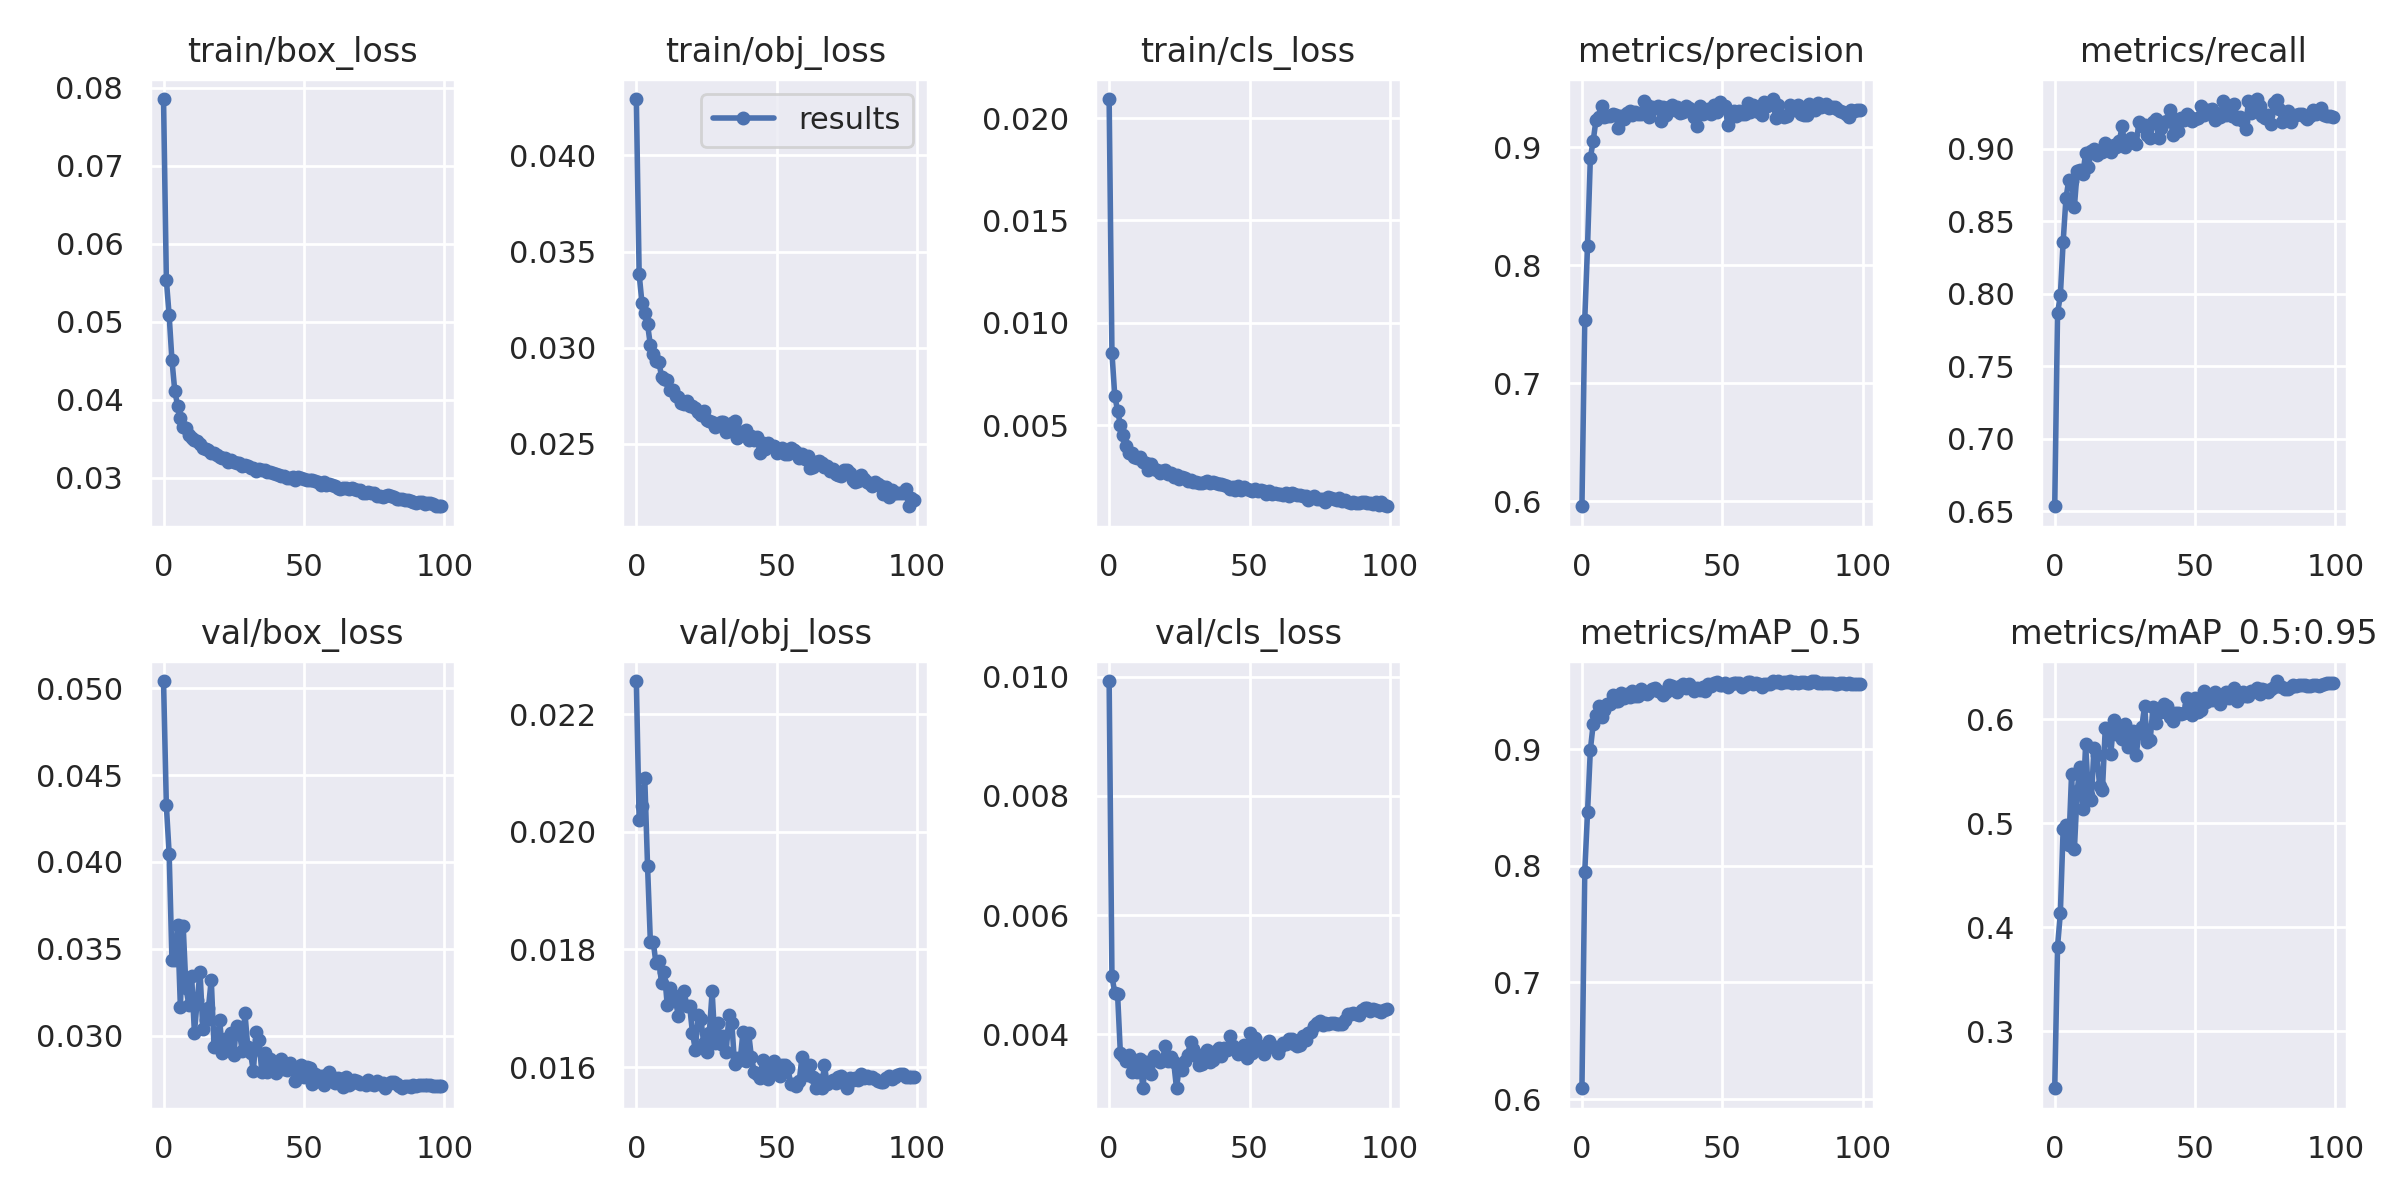

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/BestYOLO/runs/train/results/results.png', width=1000)  # view results.png

### **Visualize Our Training Data with Labels**

In [ ]:
from PIL import Image
def display_images(batch_num, folder_path, size=(12, 6)):
    # Construct the file paths for ground truth and prediction images
    gt_image_path = f"{folder_path}/val_batch{batch_num}_labels.jpg"
    pred_image_path = f"{folder_path}/val_batch{batch_num}_pred.jpg"

    # Open the images using PIL
    gt_image = Image.open(gt_image_path)
    pred_image = Image.open(pred_image_path)

    # Resize images if a size parameter is provided
    if size:
        gt_image = gt_image.resize(size)
        pred_image = pred_image.resize(size)

    # Display images side by side horizontally
    images = [gt_image, pred_image]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    new_image.show()


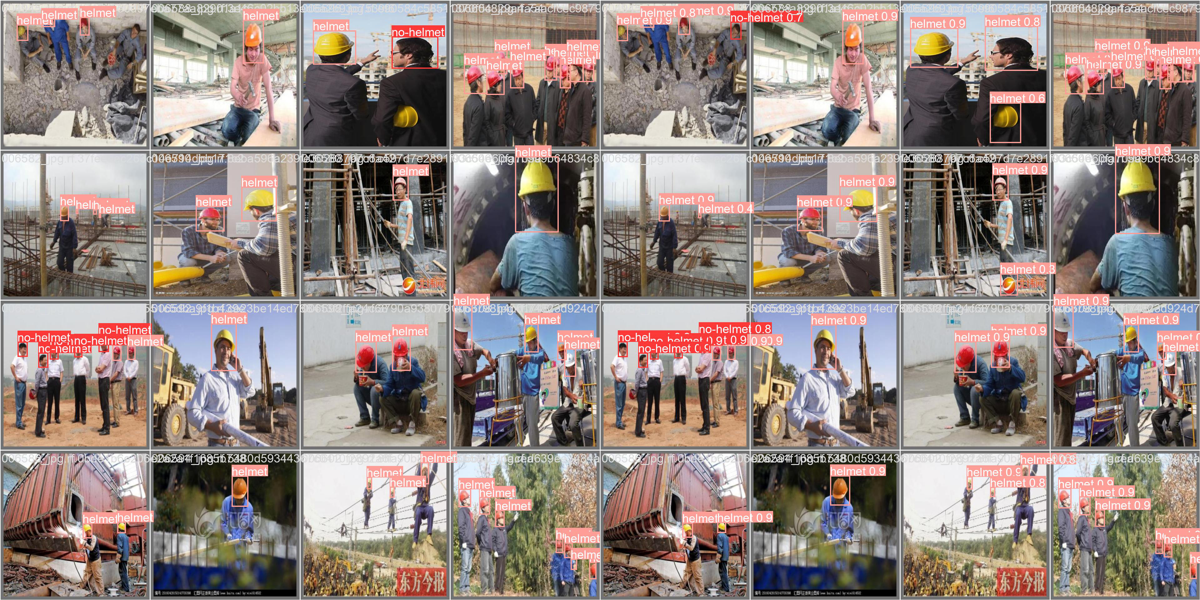

In [ ]:
folder_path = '/content/BestYOLO/runs/train/results'

display_images(0, folder_path, size=(600, 600))

In [ ]:
display_images(1, folder_path, size=(600, 600))

## **Inference with Trained Weights**

In [ ]:
os.chdir('/content/BestYOLO/')

# Run the detect.py script with multiple lines
!python detect.py \
    --weights runs/train/results/weights/best.pt \
    --img 640 \
    --conf 0.4 \
    --source /content/test/images

In [ ]:
import glob
from IPython.display import Image, display

# Define the desired width and height for the resized images
resize_width = 300
resize_height = 300

for imageName in glob.glob('/content/BestYOLO/runs/detect/exp/*.jpg'):
    # Display the image with resized dimensions
    display(Image(filename=imageName, width=resize_width, height=resize_height))
    print("\n")


# **Export Trained Weights for Future Inference**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import torch
import pickle
from datetime import datetime
import shutil

# prompt the user for the model name
model_name = input("Enter the model name: ")

# paths of the models
best_model_path = "/content/BestYOLO/runs/train/results/weights/best.pt"
last_model_path = "/content/BestYOLO/runs/train/results/weights/last.pt"

# load the models
best_model = torch.load(best_model_path)
last_model = torch.load(last_model_path)

# create a new directory in google drive with the current date and time
now = datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
new_dir_path = f"/content/gdrive/MyDrive/{timestamp_str}"
os.makedirs(new_dir_path)

# save the best model in the new directory in .pt format
torch.save(best_model, f"{new_dir_path}/{model_name}-best.pt")

# save the last model in the new directory in .pt format
torch.save(last_model, f"{new_dir_path}/{model_name}-last.pt")

# save the best model in .pkl format
with open(f"{new_dir_path}/{model_name}-best.pkl", 'wb') as f:
    pickle.dump(best_model, f)

# save the last model in .pkl format
with open(f"{new_dir_path}/{model_name}-last.pkl", 'wb') as f:
    pickle.dump(last_model, f)

print(f"Models exported to {new_dir_path} in .pt and .pkl format.")


Enter the model name: yolov5n_transformer_BiFPN_SPPCSPC-Hard Hat
Models exported to /content/gdrive/MyDrive/2023-06-09_15-52-20 in .pt and .pkl format.
